**Name:** Sandipto Sanyal
<br>**PGID:** 12010004

# Table of Contents
- [Question 1](#q1)
- [Question 2](#q2)
- [Question 3](#q3)
- [Question 4](#q4)
- [Question 5](#q5)

# Question 1 <a id='q1'></a>

## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read the dataset
Make sure data is residing at ./digi-recognizer/train.csv

In [2]:
df = pd.read_csv('./digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create combinations of class taken 2 at a time

In [3]:
from itertools import combinations
class_combinations = list(combinations(df['label'].unique(), r=2))
class_combinations

[(1, 0),
 (1, 4),
 (1, 7),
 (1, 3),
 (1, 5),
 (1, 8),
 (1, 9),
 (1, 2),
 (1, 6),
 (0, 4),
 (0, 7),
 (0, 3),
 (0, 5),
 (0, 8),
 (0, 9),
 (0, 2),
 (0, 6),
 (4, 7),
 (4, 3),
 (4, 5),
 (4, 8),
 (4, 9),
 (4, 2),
 (4, 6),
 (7, 3),
 (7, 5),
 (7, 8),
 (7, 9),
 (7, 2),
 (7, 6),
 (3, 5),
 (3, 8),
 (3, 9),
 (3, 2),
 (3, 6),
 (5, 8),
 (5, 9),
 (5, 2),
 (5, 6),
 (8, 9),
 (8, 2),
 (8, 6),
 (9, 2),
 (9, 6),
 (2, 6)]

## Compute Fischer Discriminant for each feature

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler
def perform_fischer_discriminant_computation(class_combination:tuple):
    # filter the dataset
    filtered_data = df[(df.label==class_combination[0])|(df.label==class_combination[1])]  
    ## compute the fischer scores after projection
    ### compute class means
    mu_a = np.mean(filtered_data[filtered_data['label']==class_combination[0]].drop(columns=['label']).values, axis=0)
    mu_b = np.mean(filtered_data[filtered_data['label']==class_combination[1]].drop(columns=['label']).values, axis=0)
    
    ### compute std. dev.
    sig_sq_a = np.var(filtered_data[filtered_data['label']==class_combination[0]].drop(columns=['label']).values, axis=0)
    sig_sq_b = np.var(filtered_data[filtered_data['label']==class_combination[1]].drop(columns=['label']).values, axis=0)
    
    ### compute n
    n_a = len(filtered_data[filtered_data['label']==class_combination[0]])
    n_b = len(filtered_data[filtered_data['label']==class_combination[1]])
    
    ### perform element wise multiplication
    n_a_sig_sq_a = n_a*sig_sq_a
    n_b_sig_sq_b = n_b*sig_sq_b
    
    ### compute F
    between_class_scatter = np.square(mu_a-mu_b)
    within_class_scatter = n_a_sig_sq_a + n_b_sig_sq_b
    F = between_class_scatter/within_class_scatter
    ### fill NaN values with 0: This will occur at pixels which have 0 std
    F = np.nan_to_num(F)
    
    ### accumulate only the non zero values 
    non_zero_elements = []
    for element in F:
        if element !=0:
            non_zero_elements.append(element)
    
    ### standardize rest of the F values to be within 0 to 1
    #### fit a min max scaler on non zero elements
    mms = MinMaxScaler(feature_range=(0,1))
    mms.fit(np.array(non_zero_elements).reshape(-1,1))
    #### standardize the rest of the F values using fitted min_max scaler
    F = np.vectorize(lambda element: mms.transform(np.array(element).reshape(1,-1)) if element !=0 else element)(F)
    
    # dictionary for drawing fischer diagram
    d = {'mu_a': mu_a,
         'mu_b': mu_b,
         'sig_a': np.sqrt(sig_sq_a),
         'sig_b': np.sqrt(sig_sq_b),
         'n_a': n_a,
         'n_b': n_b
        }
    return (class_combination, F, d)
    
# test the function
test = perform_fischer_discriminant_computation((6,1))
display(test)

<ipython-input-4-6fc5f3f648aa>:26: RuntimeWarning: invalid value encountered in true_divide
  F = between_class_scatter/within_class_scatter


((6, 1),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.98597513e-05, 7.98597513e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.98597513e-05, 1.06289082e-04, 2.91543941e-04, 4.54863484e-04,
        7.46559406e-04, 1.18523647e-03, 2.08225900e-03, 2.92233377e-03,
        3.35577138e-03, 3.18391710e-03, 2.83340929e-03, 2.22392766e-03,
        2.41950090e-03, 2.27557757e-03, 1.81100320e-03, 1.03939876e-03,
        7.93440619e-04, 3.11766502e-04, 2.31496502e-04, 9.19544023e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

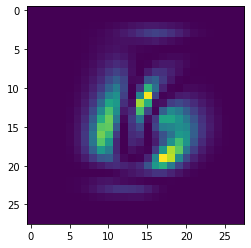

In [5]:
plt.imshow(test[1].reshape(28,28))

In [6]:
from joblib import Parallel, delayed
class_combination_lda = Parallel(n_jobs=-3, verbose=2)(delayed(perform_fischer_discriminant_computation)(class_combination) for class_combination in class_combinations)
print(class_combination_lda[0:2])

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-3)]: Done  45 out of  45 | elapsed:   13.5s finished


[((1, 0), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.68369391e-06, 1.77743009e-06,
       5.32019339e-06, 7.31193382e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+

## Create a dataframe of class combinations and fischer scores

In [7]:
full_data = []
for element in class_combination_lda:
    data_ = []
    # class combinations
    data_.append(element[0])
    # fischer scores
    data_.extend(element[1])
    # mean and sd value dictionaries
    data_.append(element[2])
    full_data.append(data_)

output_df = pd.DataFrame(full_data, columns=['class_combinations']+list(df.columns.drop('label'))+['mean_sigma_dict'])
output_df

,class_combinations,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,mean_sigma_dict
0,"(1, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,"(1, 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,"(1, 7)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000484,0.000216,0.000071,0.000046,0.000043,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,"(1, 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,"(1, 5)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,"(1, 8)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
6,"(1, 9)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000179,0.000151,0.000105,0.000066,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
7,"(1, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
8,"(1, 6)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
9,"(0, 4)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,"{'mu_a': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


## Show a heat map
In heat map let's visualize the Fischer values for pixels

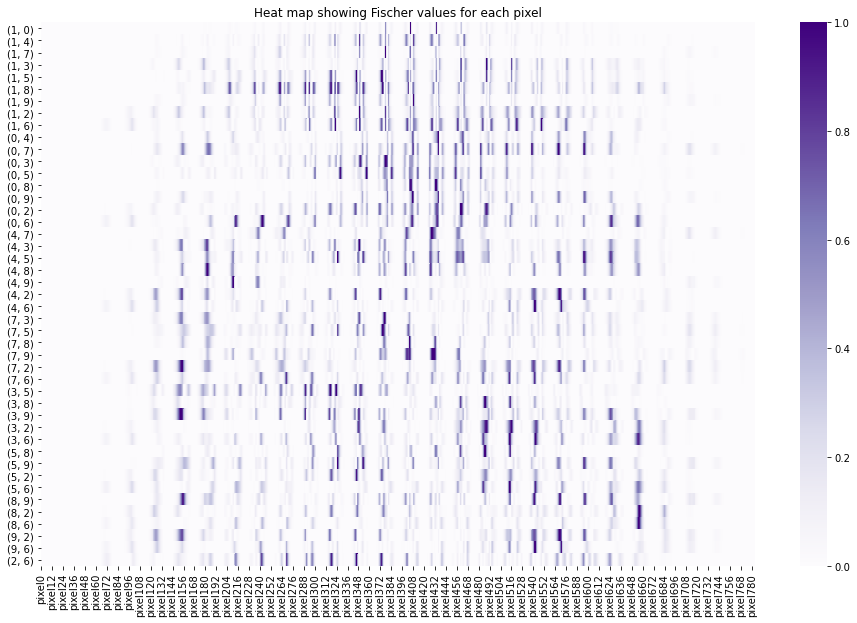

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
ax = plt.axes()
sns.heatmap(data=output_df.drop(columns=['class_combinations','mean_sigma_dict']),
            yticklabels=output_df.class_combinations,
            ax=ax,
            cmap='Purples'
           )
ax.set_title('Heat map showing Fischer values for each pixel')
plt.show()

**Observation:** So we can see that most of the high Fischer values are concetrated towards the middle pixels than towards the borders

## Visualize Fischer diagrams
Since these will be 2D plots plotting across all 784 pixels will be painful. We will perform filtering using Widgets.
Set the below widgets to have the Fischer plot associated. 
- Choose the 2 classes using **ClassA** and **ClassB**
- Set the pixel ranges to the ranges for which you want to see the Fischer Diagrams (recommended to keep within 10)

### The normal distribution diagrams
Below we will plot the pixels normal distributions to visualize whether our calculations of Fischer scores make sense. i.e. curves with less overlaps should have high Fischer values and vice versa

In [9]:
import ipywidgets as widgets
class_a = widgets.Dropdown(
    options=list(range(0,10)),
    value=1,
    description='ClassA:',
)
class_b = widgets.Dropdown(
    options=list(range(0,10)),
    value=0,
    description='ClassB:',
)
pixel = widgets.IntRangeSlider(
    value=[0,783],
    min=0,
    max=783,
    step=1,
    description='Pixels:',
    layout=widgets.Layout(width='750px')
)
display(class_a, class_b, pixel)

Dropdown(description='ClassA:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=1)

Dropdown(description='ClassB:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0)

IntRangeSlider(value=(0, 783), description='Pixels:', layout=Layout(width='750px'), max=783)

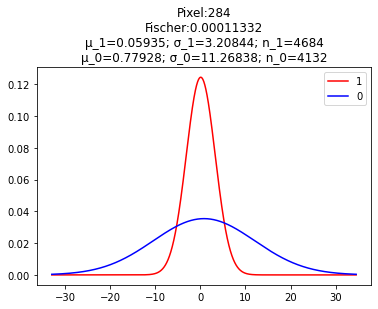

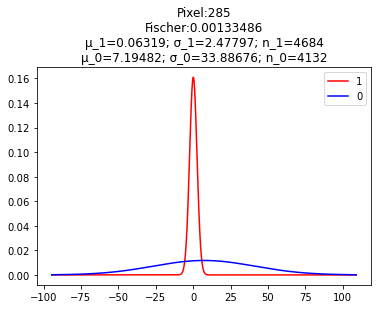

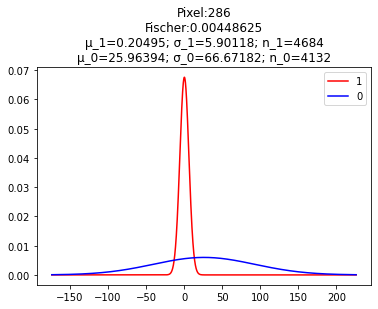

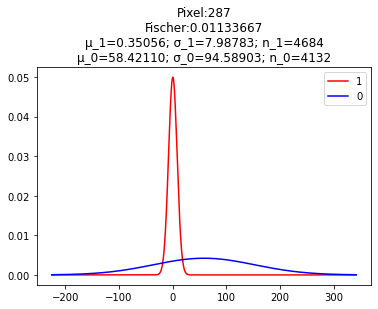

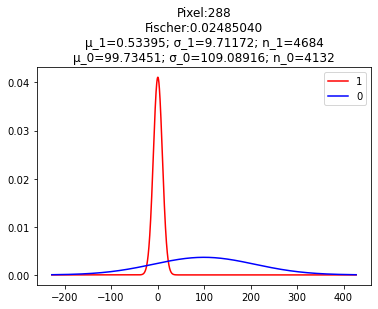

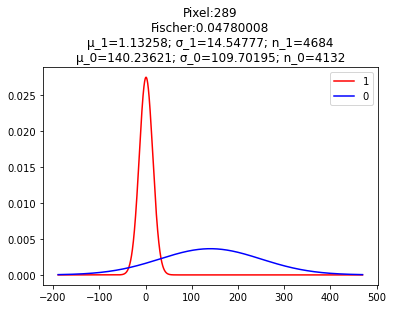

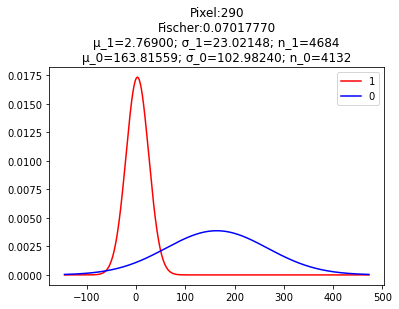

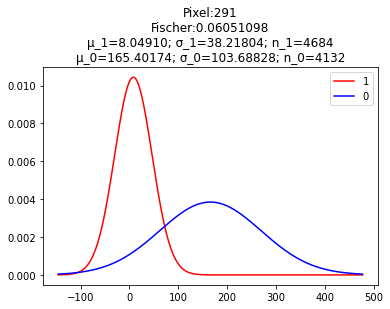

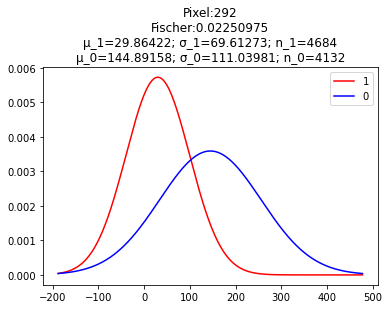

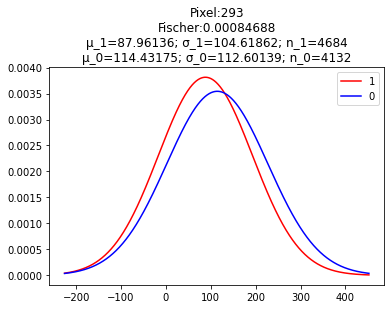

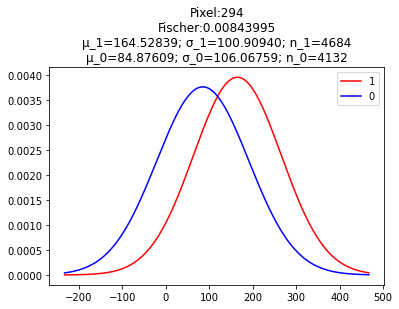

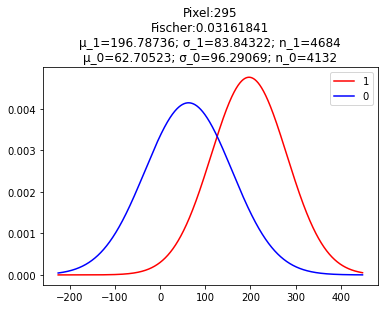

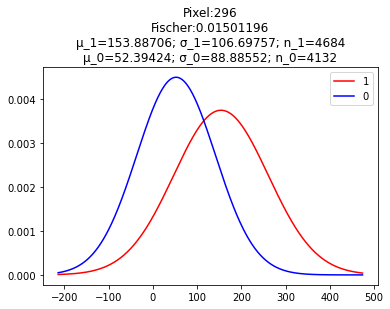

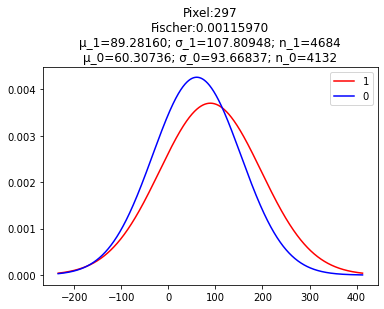

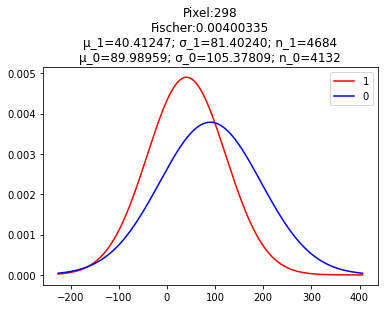

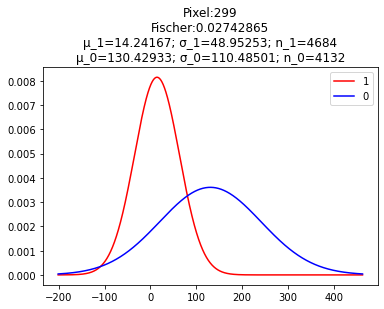

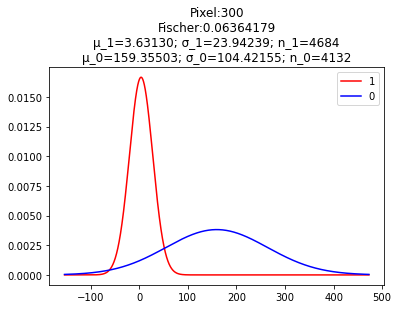

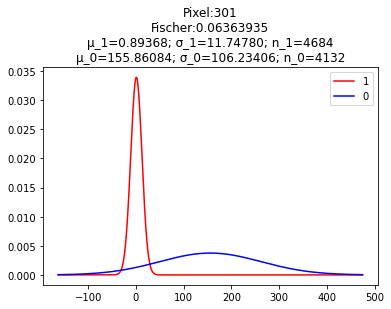

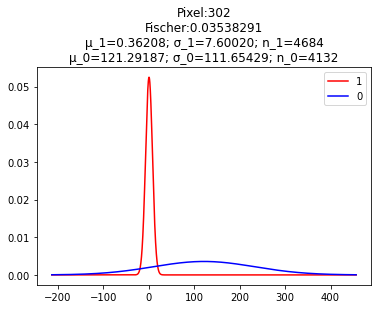

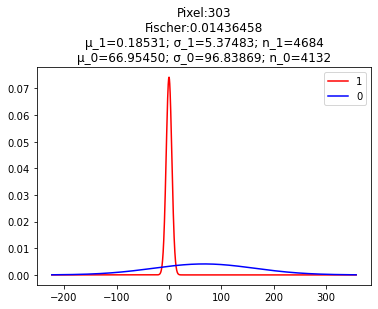

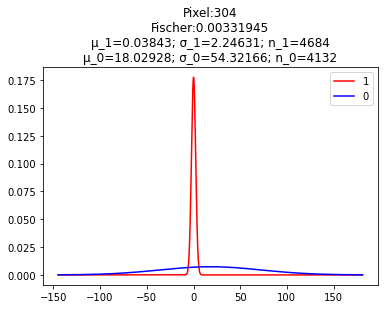

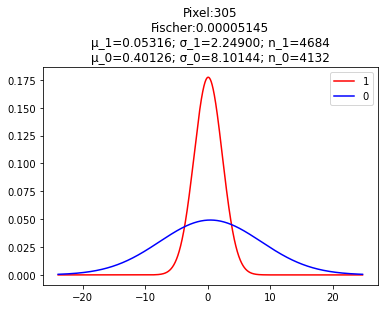

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


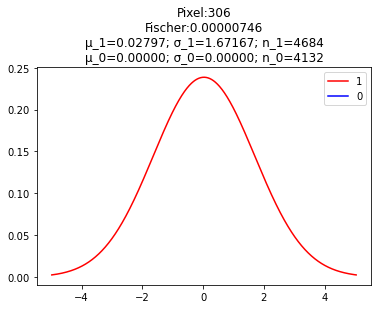

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


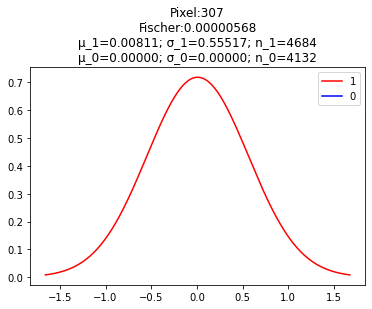

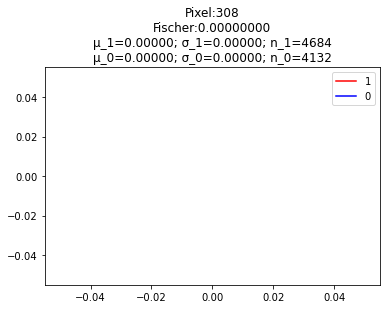

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


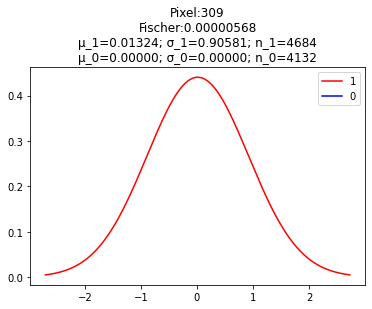

C:\Users\sandipto.sanyal\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1740: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


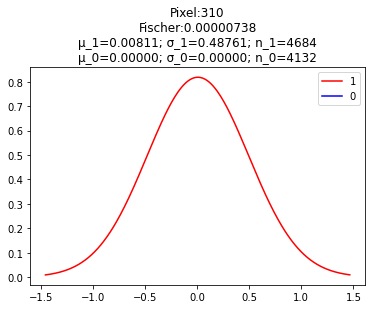

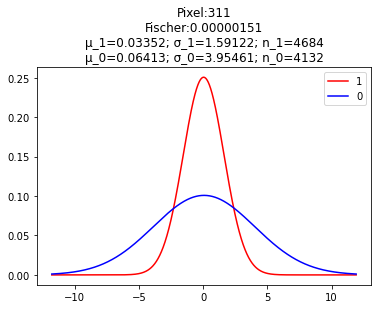

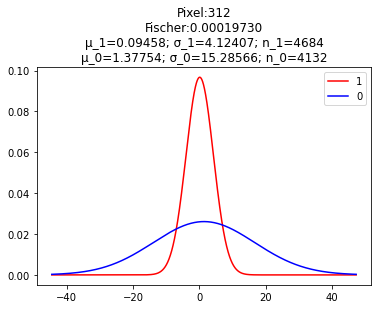

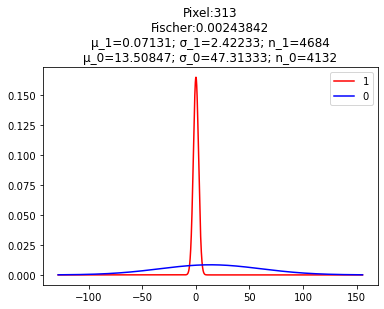

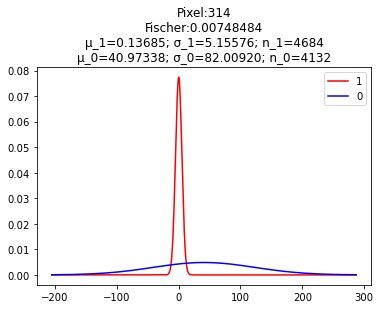

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
mu_char = '\u03BC'
sigma_char = '\u03C3'
# get the details
selected_classes_df = output_df[output_df.class_combinations==(class_a.value, class_b.value)]
# perform a validation
if len(selected_classes_df) == 0:
    selected_classes_df = output_df[output_df.class_combinations==(class_b.value, class_a.value)]
    if len(selected_classes_df) == 0:
        raise ValueError('The given class combination is invalid.')
# if validation passes print the fischer diagrams
for pixel_value in range(pixel.value[0],pixel.value[1]+1):
    # class label
    class_label_a = str(selected_classes_df.class_combinations.values[0][0])
    class_label_b = str(selected_classes_df.class_combinations.values[0][1])
    
    # get the mean values
    mu_a = selected_classes_df.mean_sigma_dict.values[0]['mu_a'][pixel_value]
    mu_b = selected_classes_df.mean_sigma_dict.values[0]['mu_b'][pixel_value]
    
    # get the std dev. values
    sig_a = selected_classes_df.mean_sigma_dict.values[0]['sig_a'][pixel_value]
    sig_b = selected_classes_df.mean_sigma_dict.values[0]['sig_b'][pixel_value]
    
    # get the n values
    n_a = selected_classes_df.mean_sigma_dict.values[0]['n_a']
    n_b = selected_classes_df.mean_sigma_dict.values[0]['n_b']
    
    # get Fischer values
    fischer = selected_classes_df['pixel{}'.format(pixel_value)].values[0]
    
    # compute normal distribution
    ## set the x_range dynamically
    multiplier = 3
    min_x_range = min(mu_a-multiplier*sig_a, mu_b-multiplier*sig_b)
    max_x_range = max(mu_a+multiplier*sig_a, mu_b+multiplier*sig_b)
    x_axis = np.arange(min_x_range, max_x_range,0.01)
    y_a = np.array(norm.pdf(x_axis, mu_a, sig_a))
    y_b = np.array(norm.pdf(x_axis, mu_b, sig_b))

    ## plot the normal distributions
    plt.plot(x_axis, y_a,color='red',label=class_label_a)
    plt.plot(x_axis, y_b,color='blue',label=class_label_b)
    title = 'Pixel:{}'\
              '\nFischer:{:.8f}'\
              '\n{}_{}={:.5f}; {}_{}={:.5f}; n_{}={}'\
              '\n{}_{}={:.5f}; {}_{}={:.5f}; n_{}={}'.format(pixel_value,
                                                              fischer,
                                                              mu_char,class_label_a,mu_a, sigma_char,class_label_a,sig_a,class_label_a,n_a,
                                                              mu_char,class_label_b,mu_b, sigma_char,class_label_b,sig_b,class_label_b,n_b
                                                              )
    plt.title(title)
    plt.legend()
    plt.show()

**Observation:** Thus from the above controls we can manually check which of the pixels are having the higher discriminatory powers for each class combinations. So our calculations are intutively correct as we are seeing higher Fischer scores for pixels having less overlaps between classes

### Visualize the Fischer images
Below we will plot the Fischer images. i.e. Reshape the array of size 784 to 28,28 and plot them

<ipython-input-11-309fe1d6ea65>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


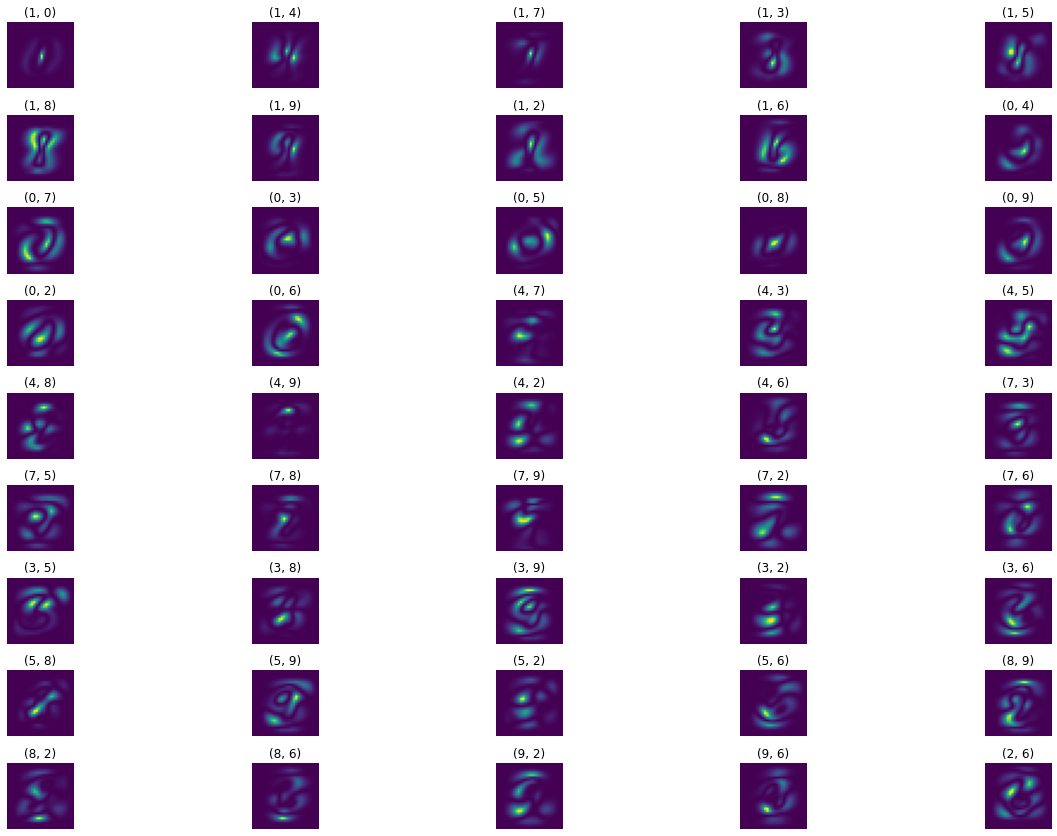

In [11]:
nrows = 9
ncols = 5
image_row_pos = 0
image_col_pos = 0
fig, ax = plt.subplots(nrows, ncols, figsize=(20,14))

for index, row in output_df.iterrows():
    fischer_pixel_values = row.drop(['class_combinations','mean_sigma_dict']).values.reshape(28,28)
    ax[image_row_pos,image_col_pos].imshow(fischer_pixel_values.astype('float32'))
    ax[image_row_pos,image_col_pos].set_title(str(row.class_combinations))
    ax[image_row_pos,image_col_pos].axis('off')
    image_col_pos += 1
    if image_col_pos == ncols:
        # reset the image_col_pos
        image_col_pos = 0
        # increase the row pos
        image_row_pos += 1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.show()

**Observation**: We can see that from the Fischer images that both the classes are superimposed over one another explaining which pixels discrimination can be used as the basis of classification.
1. for (0,1) the pixels at the middle denoting 1 and around the 'halo' around it denoting 0 are more illuminated showing greater discriminatory features along those areas
2. for (3,5) the upper part of the images are illuminated. This makes sense as pixels on the upper half of 3 and 5 gives us more discrimanatory power. The lower half doesn't.
3. for (4,6) the lower half of pixels show more discriminatory power than the upper half. This also makes sense

For all the class combinations we can see overall that both the 2 images ae sort of 

<hr style="border:0.5px solid gray"> </hr>

# Question 2 <a id='q2'></a>

## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read the dataframe

In [2]:
df = pd.read_csv('./letterrecognition-using-svm/letter-recognition.csv')
display('First 5 rows',df.head())
display('Description',df.describe())

'First 5 rows'

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


'Description'

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


## Sampling of the dataset
Below we will sample 70% data and 30% data from **each** class (not overall training dataset)

In [3]:
from sklearn.model_selection import train_test_split
train_set = pd.DataFrame(data=None, columns=df.columns)
test_set = pd.DataFrame(data=None, columns=df.columns)
test_size = 0.3
def class_extractor(data_frame:pd.DataFrame,
                    class_label:str
                   ):
    '''
    From the given dataframe extract the given class.
    Split the extracted samples into train and test
    '''
    global train_set
    global test_set
    # get the filtered dataframe
    filtered_df = data_frame[data_frame.letter==class_label]
    # perform train test split on the filtered df
    train, test = train_test_split(filtered_df,test_size=test_size)
    # concatenate to the train_set and test_set
    train_set = pd.concat([train_set, train], axis=0)
    test_set = pd.concat([test_set, test], axis=0)

for class_label in df.letter.unique():
    print('Processing label:{}'.format(class_label))
    class_extractor(data_frame=df,class_label=class_label)

Processing label:T
Processing label:I
Processing label:D
Processing label:N
Processing label:G
Processing label:S
Processing label:B
Processing label:A
Processing label:J
Processing label:M
Processing label:X
Processing label:O
Processing label:R
Processing label:F
Processing label:C
Processing label:H
Processing label:W
Processing label:L
Processing label:P
Processing label:E
Processing label:V
Processing label:Y
Processing label:Q
Processing label:U
Processing label:K
Processing label:Z


In [4]:
# get the statistics
pd.DataFrame(pd.concat([train_set.letter.value_counts(),test_set.letter.value_counts()],axis=1))

,letter,letter
U,569,244
D,563,242
P,562,241
T,557,239
M,554,238
A,552,237
Y,550,236
X,550,237
N,548,235
Q,548,235


## KNN classifier
### With Uniform weights
Here distance will not play any role. Here we will report the accuracy by varying K value.
<br><font color='red'>Warning: CPU and RAM consumption will be high. Recommended to avoid performing any other operation during execution of below cell</font>

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from joblib import Parallel, delayed
from datetime import datetime
k_values = np.arange(1, 11)
k_list = []
train_accuracy_list = []
test_accuracy_list = []
def perform_knn_training(k:int,
                         weights:str='uniform',
                        ):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(train_set.drop(columns=['letter']), train_set.letter)

    # training accuracy
    y_true = train_set.letter
    y_pred = knn.predict(train_set.drop(columns=['letter']))
    train_accuracy = accuracy_score(y_true=y_true,y_pred=y_pred)

    # test accuracy
    y_true = test_set.letter
    y_pred = knn.predict(test_set.drop(columns=['letter']))
    test_accuracy = accuracy_score(y_true=y_true,y_pred=y_pred)
    # return the accuracy and k
    return (k, train_accuracy, test_accuracy)
start = datetime.now()
accuracies_k = Parallel(n_jobs=-3, verbose=2)(delayed(perform_knn_training)(k) for k in k_values)
end = datetime.now()
print('Parallelized time consumed::',end-start)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:  1.6min remaining:  3.7min


Parallelized time consumed:: 0:01:46.127658


[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.8min finished


#### Plot the train and test accuracies

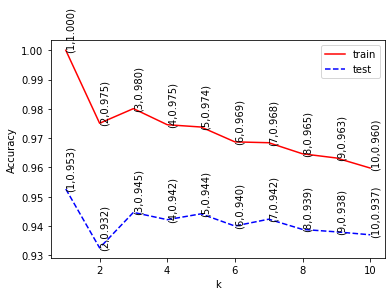

In [6]:
k_list = []
train_accuracy_list = []
test_accuracy_list = []
for k, train_accuracy, test_accuracy in accuracies_k:
    k_list.append(k)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
plt.plot(k_list, train_accuracy_list, '-r',label='train')
plt.plot(k_list, test_accuracy_list, '--b',label='test')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()

# add annotation
for x, y in zip(k_list, train_accuracy_list):
    text = '({},{:.3f})'.format(x,y)
    plt.text(x,y,text,rotation=90)
    
for x, y in zip(k_list, test_accuracy_list):
    text = '({},{:.3f})'.format(x,y)
    plt.text(x,y,text,rotation=90)
plt.show()

**Observation:** Here we can see that at **k=3** we have **train_accuracy = 0.979** and **test accuracy = 0.95**. This is one peak. At **k=1 (total overfit condition)** we have train accuracy as **1** and **test accuracy = 0.958**. Obviously both have increased than the previous peak at k=3, so if we go by %age increase in accuracies between these 2 peaks we get:<br>
- Train %age increase = $\frac{(1-0.979)}{0.979} = 2.14\% $
- Test %age increase = $\frac{(0.958-0.950)}{0.950} = 0.8\% $

Hence k=3 is the **sweet spot**

### Parzen Window

#### Kernel Density Estimator
This method will compute the following:<br>
$$ K_{\sigma}(x,x_{n}) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left( -\frac{(x-x_{n})^{2}}{2\sigma^2} \right) $$

<br>Where 
- $x$ = Point in the dataset
- $x_{n}$ = Incoming point
- $\sigma$ = Kernel density estimator's hyper parameter

In n dimensions $(x-x_{n})^{2}$ will be distance square.

As per the scikit-learn KNN documentation ([link](#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) it says we can call a custom weighting function (similar to our) $ K_{\sigma}(x,x_{n}) $ and return the weights

In [7]:
def compute_k(distances):
    global sigma
    '''
    distances: np.ndarray
    '''
    print('Sigma received: ', sigma)
    distance_square = np.square(distances)
    K_sigma = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-distance_square/(2*np.square(sigma)))
    return K_sigma
# test the function
sigma = 2
temp = compute_k
temp([0,1,2,3,555])

Sigma received:  2


array([0.19947114, 0.17603266, 0.12098536, 0.0647588 , 0.        ])

#### Perform KNN classification
Below we will perform KNN classification with K=3 (decided above) and sigma varying between 1 to 10.
<br><font color='red'>Warning: CPU and RAM consumption will be high. Recommended to avoid performing any other operation during execution of below cell</font>

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from joblib import Parallel, delayed
sigma_values = np.arange(1, 11)
k_list = []
train_accuracy_list = []
test_accuracy_list = []
sigma = 1
def perform_knn_training(sigma_val:int):
    global sigma 
    sigma = sigma_val
    knn = KNeighborsClassifier(n_neighbors=3, weights=compute_k)
    knn.fit(train_set.drop(columns=['letter']), train_set.letter)

    # training accuracy
    y_true = train_set.letter
    y_pred = knn.predict(train_set.drop(columns=['letter']))
    train_accuracy = accuracy_score(y_true=y_true,y_pred=y_pred)

    # test accuracy
    y_true = test_set.letter
    y_pred = knn.predict(test_set.drop(columns=['letter']))
    test_accuracy = accuracy_score(y_true=y_true,y_pred=y_pred)
    # return the accuracy and k
    return (sigma, train_accuracy, test_accuracy)
# accuracies_k = Parallel(n_jobs=-3, verbose=2)(delayed(perform_knn_training)(sigma) for sigma in sigma_values)
accuracies_k = [perform_knn_training(sigma) for sigma in sigma_values]
accuracies_k

Sigma received:  1
Sigma received:  1
Sigma received:  2
Sigma received:  2
Sigma received:  3
Sigma received:  3
Sigma received:  4
Sigma received:  4
Sigma received:  5
Sigma received:  5
Sigma received:  6
Sigma received:  6
Sigma received:  7
Sigma received:  7
Sigma received:  8
Sigma received:  8
Sigma received:  9
Sigma received:  9
Sigma received:  10
Sigma received:  10


[(1, 1.0, 0.9575777740808518),
 (2, 0.9969976410036457, 0.9530860089835302),
 (3, 0.9885624419186504, 0.9515887539510897),
 (4, 0.9864178997783973, 0.9510896689402761),
 (5, 0.9862749303023804, 0.9510896689402761),
 (6, 0.9862749303023804, 0.9510896689402761),
 (7, 0.9862749303023804, 0.9510896689402761),
 (8, 0.9862749303023804, 0.9510896689402761),
 (9, 0.9862749303023804, 0.9510896689402761),
 (10, 0.9862749303023804, 0.9510896689402761)]

#### Plot the train and test accuracies

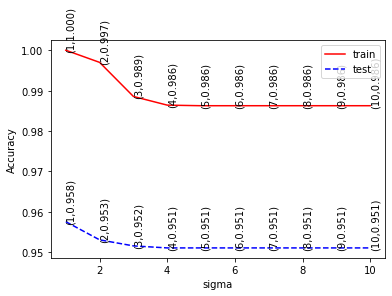

In [9]:
sigma_list = []
train_accuracy_list = []
test_accuracy_list = []
for sigma, train_accuracy, test_accuracy in accuracies_k:
    sigma_list.append(sigma)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
plt.plot(sigma_list, train_accuracy_list, '-r',label='train')
plt.plot(sigma_list, test_accuracy_list, '--b',label='test')
plt.xlabel('sigma')
plt.ylabel('Accuracy')
plt.legend()

# add annotation
for x, y in zip(sigma_list, train_accuracy_list):
    text = '({},{:.3f})'.format(x,y)
    plt.text(x,y,text,rotation=90)
    
for x, y in zip(sigma_list, test_accuracy_list):
    text = '({},{:.3f})'.format(x,y)
    plt.text(x,y,text,rotation=90)
plt.show()

**Observation:** Here $\sigma = 1$ denotes over fit condition. So again going by percentage increase in accuracy from $\sigma=2$ we get:
- Train set %age increase = $\frac{1-0.997}{0.997}= 0.3\%$
- Train set %age increase = $\frac{0.960-0.957}{0.957}= 0.3\%$

So as per our understanding, 0.3% increase is not a significant increase in accuracy where we can see that the model is operating at overfit condition. Thus the sweet spot lies at $\sigma=2$

<hr style="border:0.5px solid gray"> </hr>

# Question 3 <a id='q3'></a>
SVM with 1-vs. rest classification

## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read the dataframe
Make sure data is residing at ./letterrecognition-using-svm/letter-recognition.csv

In [2]:
df = pd.read_csv('./letterrecognition-using-svm/letter-recognition.csv')
display('First 5 rows',df.head())
display('Description',df.describe())

'First 5 rows'

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


'Description'

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


## Sampling of the dataset
Below we will sample 70% data and 30% data from **each** class (not overall training dataset)

In [3]:
from sklearn.model_selection import train_test_split
train_set = pd.DataFrame(data=None, columns=df.columns)
test_set = pd.DataFrame(data=None, columns=df.columns)
test_size = 0.3
def class_extractor(data_frame:pd.DataFrame,
                    class_label:str
                   ):
    '''
    From the given dataframe extract the given class.
    Split the extracted samples into train and test
    '''
    global train_set
    global test_set
    # get the filtered dataframe
    filtered_df = data_frame[data_frame.letter==class_label]
    # perform train test split on the filtered df
    train, test = train_test_split(filtered_df,test_size=test_size)
    # concatenate to the train_set and test_set
    train_set = pd.concat([train_set, train], axis=0)
    test_set = pd.concat([test_set, test], axis=0)

for class_label in df.letter.unique():
    print('Processing label:{}'.format(class_label))
    class_extractor(data_frame=df,class_label=class_label)

Processing label:T
Processing label:I
Processing label:D
Processing label:N
Processing label:G
Processing label:S
Processing label:B
Processing label:A
Processing label:J
Processing label:M
Processing label:X
Processing label:O
Processing label:R
Processing label:F
Processing label:C
Processing label:H
Processing label:W
Processing label:L
Processing label:P
Processing label:E
Processing label:V
Processing label:Y
Processing label:Q
Processing label:U
Processing label:K
Processing label:Z


In [4]:
# get the statistics
pd.DataFrame(pd.concat([train_set.letter.value_counts(),test_set.letter.value_counts()],axis=1))

,letter,letter
U,569,244
D,563,242
P,562,241
T,557,239
M,554,238
A,552,237
Y,550,236
X,550,237
N,548,235
Q,548,235


## Create the hyper parameter dictionary

In [5]:
hyper_parameter_list = [{'C':1, 'kernel':'linear','degree':1},
                         {'C':5, 'kernel':'linear','degree':1},
                         {'C':10, 'kernel':'linear','degree':1},
                         {'C':5, 'kernel':'poly','degree':2},
                         {'C':5, 'kernel':'poly','degree':3},
                         {'C':5, 'kernel':'rbf','degree':1}
                        ]

## Build the classifier

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def train_svm(positive_class:str):
    # change the labels
    tmp_train_df = train_set.copy()
    tmp_test_df = test_set.copy()
    tmp_train_df.loc[tmp_train_df['letter']!=positive_class, 'letter']=0 # other classes as 0
    tmp_train_df.loc[tmp_train_df['letter']==positive_class, 'letter']=1 # positive class as 1
    
    
    tmp_test_df.loc[tmp_test_df['letter']!=positive_class, 'letter']=0 # other classes as 0
    tmp_test_df.loc[tmp_test_df['letter']==positive_class, 'letter']=1 # positive class as 1
    
    
    # create SVCs
    accuracy_list = []
    accuracy_list.append(positive_class)
    for hyper_param in hyper_parameter_list:
        C = hyper_param['C']
        kernel = hyper_param['kernel']
        degree = hyper_param['degree']
        clf = SVC(C=C, kernel=kernel, degree=degree)
        clf.fit(tmp_train_df.drop(columns=['letter']),tmp_train_df.letter.astype('int'))        
        # get predictions
        acc_test = accuracy_score(y_true=tmp_test_df.letter.astype('int'), y_pred=clf.predict(tmp_test_df.drop(columns=['letter'])))
        accuracy_list.append(acc_test)
    
    # return the values
    return accuracy_list
train_svm(positive_class='A')

['A',
 0.9928464481783397,
 0.9928464481783397,
 0.9928464481783397,
 0.9960073199134919,
 0.9975045749459325,
 0.997005489935119]

## Run the above function in parallel
<font color='red'>Warning: CPU and RAM consumption will be high. Recommended to avoid performing any other operation during execution of below cell</font>

In [7]:
from joblib import Parallel, delayed
positive_class_list = sorted(df.letter.unique())
accuracy_positive_class = Parallel(n_jobs=-3, verbose=2)(delayed(train_svm)(positive_class) for positive_class in positive_class_list)
accuracy_positive_class[0:5]

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 out of  26 | elapsed:  1.9min remaining:   27.3s
[Parallel(n_jobs=-3)]: Done  26 out of  26 | elapsed:  2.0min finished


[['A',
  0.9928464481783397,
  0.9928464481783397,
  0.9928464481783397,
  0.9960073199134919,
  0.9975045749459325,
  0.997005489935119],
 ['B',
  0.961736815837631,
  0.961736815837631,
  0.961736815837631,
  0.9850274496755947,
  0.9898519381134586,
  0.9893528531026452],
 ['C',
  0.9757111961404092,
  0.9760439194809516,
  0.9760439194809516,
  0.9913491931458992,
  0.9956745965729495,
  0.993179171518882],
 ['D',
  0.97155215438363,
  0.97155215438363,
  0.97155215438363,
  0.9895192147729163,
  0.9916819164864416,
  0.9926800865080685],
 ['E',
  0.9615704541673599,
  0.9615704541673599,
  0.9615704541673599,
  0.9818665779404425,
  0.9913491931458992,
  0.9905173847945433]]

## Put everything in Dataframe

In [8]:
cols = ['target_class']+[str(hyper_param) for hyper_param in hyper_parameter_list]
pd.DataFrame(data=accuracy_positive_class, columns=cols)

,target_class,"{'C': 1, 'kernel': 'linear', 'degree': 1}","{'C': 5, 'kernel': 'linear', 'degree': 1}","{'C': 10, 'kernel': 'linear', 'degree': 1}","{'C': 5, 'kernel': 'poly', 'degree': 2}","{'C': 5, 'kernel': 'poly', 'degree': 3}","{'C': 5, 'kernel': 'rbf', 'degree': 1}"
0,A,0.992846,0.992846,0.992846,0.996007,0.997505,0.997005
1,B,0.961737,0.961737,0.961737,0.985027,0.989852,0.989353
2,C,0.975711,0.976044,0.976044,0.991349,0.995675,0.993179
3,D,0.971552,0.971552,0.971552,0.989519,0.991682,0.992680
4,E,0.961570,0.961570,0.961570,0.981867,0.991349,0.990517
5,F,0.968724,0.968724,0.968724,0.986525,0.992015,0.991516
6,G,0.961404,0.961404,0.961404,0.978040,0.991516,0.992680
7,H,0.963234,0.963234,0.963234,0.974547,0.986358,0.984362
8,I,0.983697,0.983697,0.983697,0.994177,0.996506,0.996007
9,J,0.987689,0.987689,0.987689,0.994177,0.995675,0.995841


**Observation:** 
1. As C increases for linear kernels there is no substantial increase in accuracy.
1. As we are moving from linear kernel to polynomial and RBF we are seeing substantial increase in accuracy for same C=5. Also within polynomial kernel there is substantial accuracy increase when we are increasing the degree.

<hr style="border:0.5px solid gray"> </hr>

# Question 4 <a id='q4'></a>
SVM with pairwise classification

## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read the dataframe

In [2]:
df = pd.read_csv('./letterrecognition-using-svm/letter-recognition.csv')
display('First 5 rows',df.head())
display('Description',df.describe())

'First 5 rows'

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


'Description'

,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


## Sampling of the dataset
Below we will sample 70% data and 30% data from **each** class (not overall training dataset)

In [3]:
from sklearn.model_selection import train_test_split
train_set = pd.DataFrame(data=None, columns=df.columns)
test_set = pd.DataFrame(data=None, columns=df.columns)
test_size = 0.3
def class_extractor(data_frame:pd.DataFrame,
                    class_label:str
                   ):
    '''
    From the given dataframe extract the given class.
    Split the extracted samples into train and test
    '''
    global train_set
    global test_set
    # get the filtered dataframe
    filtered_df = data_frame[data_frame.letter==class_label]
    # perform train test split on the filtered df
    train, test = train_test_split(filtered_df,test_size=test_size)
    # concatenate to the train_set and test_set
    train_set = pd.concat([train_set, train], axis=0)
    test_set = pd.concat([test_set, test], axis=0)

for class_label in df.letter.unique():
    print('Processing label:{}'.format(class_label))
    class_extractor(data_frame=df,class_label=class_label)

Processing label:T
Processing label:I
Processing label:D
Processing label:N
Processing label:G
Processing label:S
Processing label:B
Processing label:A
Processing label:J
Processing label:M
Processing label:X
Processing label:O
Processing label:R
Processing label:F
Processing label:C
Processing label:H
Processing label:W
Processing label:L
Processing label:P
Processing label:E
Processing label:V
Processing label:Y
Processing label:Q
Processing label:U
Processing label:K
Processing label:Z


In [4]:
# get the statistics
pd.DataFrame(pd.concat([train_set.letter.value_counts(),test_set.letter.value_counts()],axis=1))

,letter,letter
U,569,244
D,563,242
P,562,241
T,557,239
M,554,238
A,552,237
X,550,237
Y,550,236
Q,548,235
N,548,235


## Create combination of classes
The combination of each classes taken 2 at a time

In [5]:
from itertools import combinations
list_of_combinations = list(combinations(sorted(df.letter.unique()), r=2))
list_of_combinations

[('A', 'B'),
 ('A', 'C'),
 ('A', 'D'),
 ('A', 'E'),
 ('A', 'F'),
 ('A', 'G'),
 ('A', 'H'),
 ('A', 'I'),
 ('A', 'J'),
 ('A', 'K'),
 ('A', 'L'),
 ('A', 'M'),
 ('A', 'N'),
 ('A', 'O'),
 ('A', 'P'),
 ('A', 'Q'),
 ('A', 'R'),
 ('A', 'S'),
 ('A', 'T'),
 ('A', 'U'),
 ('A', 'V'),
 ('A', 'W'),
 ('A', 'X'),
 ('A', 'Y'),
 ('A', 'Z'),
 ('B', 'C'),
 ('B', 'D'),
 ('B', 'E'),
 ('B', 'F'),
 ('B', 'G'),
 ('B', 'H'),
 ('B', 'I'),
 ('B', 'J'),
 ('B', 'K'),
 ('B', 'L'),
 ('B', 'M'),
 ('B', 'N'),
 ('B', 'O'),
 ('B', 'P'),
 ('B', 'Q'),
 ('B', 'R'),
 ('B', 'S'),
 ('B', 'T'),
 ('B', 'U'),
 ('B', 'V'),
 ('B', 'W'),
 ('B', 'X'),
 ('B', 'Y'),
 ('B', 'Z'),
 ('C', 'D'),
 ('C', 'E'),
 ('C', 'F'),
 ('C', 'G'),
 ('C', 'H'),
 ('C', 'I'),
 ('C', 'J'),
 ('C', 'K'),
 ('C', 'L'),
 ('C', 'M'),
 ('C', 'N'),
 ('C', 'O'),
 ('C', 'P'),
 ('C', 'Q'),
 ('C', 'R'),
 ('C', 'S'),
 ('C', 'T'),
 ('C', 'U'),
 ('C', 'V'),
 ('C', 'W'),
 ('C', 'X'),
 ('C', 'Y'),
 ('C', 'Z'),
 ('D', 'E'),
 ('D', 'F'),
 ('D', 'G'),
 ('D', 'H'),
 ('D', 'I'),

## Build the classifier

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from typing import Tuple
def train_svm(positive_negative_pair:Tuple[str]):
    positive_class = positive_negative_pair[0]
    negative_class = positive_negative_pair[1]
    # change the labels
    tmp_train_df = train_set[(train_set.letter==positive_class)|(train_set.letter==negative_class)]
    tmp_test_df = test_set[(test_set.letter==positive_class)|(test_set.letter==negative_class)]
    tmp_train_df.loc[tmp_train_df['letter']!=positive_class, 'letter']=0 # other classes as 0
    tmp_train_df.loc[tmp_train_df['letter']==positive_class, 'letter']=1 # positive class as 1
    
    tmp_test_df.loc[tmp_test_df['letter']!=positive_class, 'letter']=0 # other classes as 0
    tmp_test_df.loc[tmp_test_df['letter']==positive_class, 'letter']=1 # positive class as 1
        
    # create SVC
    accuracy_list = []
    # append the positive and negative classes
    accuracy_list.append(positive_class)
    accuracy_list.append(negative_class)
    C = 5
    kernel = 'linear'
    degree = 1
    clf = SVC(C=C, kernel=kernel, degree=degree)
    clf.fit(tmp_train_df.drop(columns=['letter']),tmp_train_df.letter.astype('int'))
    
    # get predictions
    acc_test = accuracy_score(y_true=tmp_test_df.letter.astype('int'), y_pred=clf.predict(tmp_test_df.drop(columns=['letter'])))
    accuracy_list.append(acc_test)
    # return the values
    return accuracy_list
train_svm(positive_negative_pair=('H','R'))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


['H', 'R', 0.8841870824053452]

## Run the above function in parallel
<font color='red'>Warning: CPU and RAM consumption will be high. Recommended to avoid performing any other operation during execution of below cell</font>

In [7]:
from joblib import Parallel, delayed
accuracy_positive_class = Parallel(n_jobs=-3, verbose=2)(delayed(train_svm)(positive_negative_pair) for positive_negative_pair in list_of_combinations)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  21 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-3)]: Done 142 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-3)]: Done 325 out of 325 | elapsed:   13.3s finished


## Put everything in Dataframe

In [8]:
pd.set_option('display.max_rows', 1000)
cols = ['positive_class','negative_class','linear_c5']
pd.DataFrame(data=accuracy_positive_class, columns=cols).sort_values(['linear_c5','positive_class'],ascending=[False,True])

,positive_class,negative_class,linear_c5
3,A,E,1.000000
4,A,F,1.000000
21,A,W,1.000000
25,B,C,1.000000
43,B,U,1.000000
47,B,Y,1.000000
55,C,J,1.000000
64,C,S,1.000000
70,C,Y,1.000000
71,C,Z,1.000000


**Observation:** The classes which are showing highest accuracies denote that they are most different like ('A','E'); ('B','C') etc. The classes where the accuracies are lowest like ('H', 'O'); ('S', 'Z'); ('F','P') are most similar.

<hr style="border:0.5px solid gray"> </hr>

# Question 5 <a id='q5'></a>

## Restart the kernel

In [ ]:
import os
os._exit(00)

## Library Import

In [1]:
# !pip install treelib
# !pip install graphviz

## Create binary search model trainer

### Create a binary tree class
Binary tree class provides capability to add nodes (left and right) to given parents. Each node stores below metadata:
- model: the regression model. In this exercise we will use linear regression model. But it can store any model provided it has predict() method
- rmse: rmse for the given node
- x_range: the domain for which the node will perform prediction
- y_range: the range of the regression

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 31 11:24:38 2021

@author: sandipto.sanyal
"""

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import math
from treelib import Node, Tree
import os

class BinaryTreeNode:
    def __init__(self,
                 model,
                 rmse,
                 x_range:np.ndarray,
                 y_range:np.ndarray,
                 ):
        '''
        

        Parameters
        ----------
        model : TYPE
            Regression model. Must have .predict() method
        rmse : float
            The RMSE calculated by the given model
        x_range : np.ndarray
            The range of values of x for which the model is valid
        y_range : np.ndarray
            The range of values of y for which the model is valid. 
            (Applicable for train set only)

        Returns
        -------
        None.
        
        Attributes
        ----------
        parent: The parent of a particular node
        left: The left child
        right: the right child
        rmse: RMSE
        model: Regression model
        x_range: domain of the function
        y_range: range of the function

        '''
        self.parent = None
        self.left = None
        self.right = None
        self.rmse = None
        self.model = model # fitted model
        self.rmse = rmse # the rmse of the model
        self.x_range = x_range
        self.y_range = y_range

class BinaryTree:
    '''
    Attributes
    ----------
    n_elements: Total number of nodes of the tree. Increases with each insertion
    root: the root element of the tree
    
    '''
    
    def __init__(self):
        self.n_elements = 0
        self.root = None
    def insertLeft(self,
                   model, 
                   rmse, 
                   parent,
                   x_range,
                   y_range
                   ):
        # check if parent has node attahced on left
        error = f'Error: Left of parent node {parent} is occupied'
        assert parent.left == None, error
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        parent.left = newNode
        parent.left.parent = parent
        self.n_elements += 1
        return newNode
    
    def insertRight(self,
                    model, 
                    rmse, 
                    parent,
                    x_range,
                    y_range
                    ):
        # check if parent has node attahced on left
        error = f'Error: Left of parent node {parent} is occupied'
        assert parent.right == None, error
    
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        parent.right = newNode
        parent.right.parent = parent
        self.n_elements += 1
        return newNode
    
    def initial_insert(self,
                       model, 
                       rmse, 
                       x_range,
                       y_range
                       ):
        error = f'Root already created {self.root}'
        assert self.root == None, error
        newNode = BinaryTreeNode(model=model,
                                 rmse=rmse,
                                 x_range=x_range,
                                 y_range=y_range
                                 )
        self.root = newNode
        self.n_elements += 1
        return self.root

### Create the LLE modeling class
This class will perform sequential training on passed X and y values.

In [3]:
class LLE:
    def __init__(self,
                 rmse_threshold:float,
                 split_steps: int=1,
                 verbose: int=1,
                 split_type: str='greedy'
                 ):
        '''
        

        Parameters
        ----------
        rmse_threshold : float
            The RMSE threshold for each node. RMSE of node > threshold
            makes the node eligible for split. 
            Lower values will take higher time for the algo to converge
        
        split_steps : int (optional) default 1
            The steps of splits of X Y region to test for splits giving 
            best RMSE. 
            Higher values --> lower splits --> lesser trials --> faster
            convergence --> less accurate
            
        verbose : int (optional) default 1
            Verbosity to control visualizing intermediate model splitting
            plots
            
        split_type : str (optional) default 'greedy'
            Allowable values: ['greedy','binary']
            The node splitting mechanism. 
            1. Greedy denotes each node is splitted by selecting
            the split positions which gives overall the least RMSE where
            RMSE = n_left * rmse_left + n_right * rmse_right. This is slower
            algorithm than binary
            2. Binary denotes each node is splitted by bisecting the X axis.
            Faster than greedy but less accurate
        Returns
        -------
        None.
        
        Attributes
        ----------
        rmse_threshold: the RMSE threshold passed as hyper parameter
        BinaryTree: class BinaryTree. This will store the whole tree structre as objects.

        '''
        self.rmse_threshold = rmse_threshold
        self.BinaryTree = BinaryTree()
        self.tree = Tree()
        self.final_models = {}
        self.split_steps = split_steps
        self.verbose = verbose
        self.split_type = split_type
        
    def perform_regression(self,
                           X, y
                           ):
        '''
        

        Parameters
        ----------
        X : TYPE
            DESCRIPTION.
        y : TYPE
            DESCRIPTION.

        Returns
        -------
        reg : TYPE
            DESCRIPTION.
        rmse : TYPE
            DESCRIPTION.

        '''
        # fit a model on X and y
        reg = LinearRegression()
        reg.fit(X, y)
        # run prediction
        y_pred = reg.predict(X)
        # calculate rmse
        rmse = mean_squared_error(y_true=y, y_pred=y_pred,squared=False)
        rmse = len(X)*rmse
        return reg, rmse
    
    
    def plot_subplots(self,
                      X,
                      y,
                      models:list,
                      X_left,                      
                      X_right,
                      rmse: float
                      ):
        plt.plot(X,y,'-b', label='actual')
        # left plot
        plt.plot(X_left,models[0].predict(X_left).reshape(-1,),'--r',label='left pred')
        plt.plot(X_right,models[1].predict(X_right).reshape(-1,),'--k',label='right pred')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('RMSE:{:.3f}'.format(rmse))
        plt.show()
        
        
    def get_best_split(self,
                       X:np.ndarray,
                       y:np.ndarray
                       ):
        '''
        This method will split the X and y into different regions and perform
        linear regression to get the split position giving the best RMSE

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.

        Returns
        -------
        None.

        '''
        split_positions = np.arange(1, len(X), self.split_steps)
        min_rmse = np.inf
        best_split_pos = None
        best_left_reg = None
        best_right_reg = None
        best_rmse_left = np.inf
        best_rmse_right = np.inf
        for split_pos in split_positions:
            X_left = X[0:split_pos]
            X_right = X[split_pos:]
            y_left = y[0:split_pos]
            y_right = y[split_pos:]
            reg_left, rmse_left = self.perform_regression(X_left, y_left)
            reg_right, rmse_right = self.perform_regression(X_right, y_right)
            rmse_at_split_pos = rmse_left + rmse_right
            
            # update the best candidates
            if rmse_at_split_pos < min_rmse:
                min_rmse = rmse_at_split_pos
                best_split_pos = split_pos
                best_left_reg = reg_left
                best_right_reg = reg_right
                best_rmse_left = rmse_left
                best_rmse_right = rmse_right
        
        return (best_split_pos, 
                best_left_reg, 
                best_right_reg, 
                best_rmse_left,
                best_rmse_right
                )
                
        
    
    
    def split_node_binary(self,
                   X:np.ndarray,
                   y:np.ndarray,
                   parent
                   ):
        '''
        This performs only binary split

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.
        parent : TYPE
            DESCRIPTION.

        Returns
        -------
        rmse_left : TYPE
            DESCRIPTION.
        rmse_right : TYPE
            DESCRIPTION.

        '''
        
        # split the x axis into half
        split_pos = math.floor(int(len(X)/2))
        X_left = X[0:split_pos]
        X_right = X[split_pos:]
        y_left = y[0:split_pos]
        y_right = y[split_pos:]
        
        # perform regression
        reg, rmse_left = self.perform_regression(X_left, y_left)
        # insert into left node
        current_left = self.BinaryTree.insertLeft(model=reg, 
                                            rmse=rmse_left, 
                                            parent=parent, 
                                            x_range=X_left,
                                            y_range=y_left
                                            )
        self.stack_of_nodes.append(current_left)
        node_id = f'L-{self.BinaryTree.n_elements}\n'\
            f'{str(current_left)[-5:-1]}\n'\
                f'rmse:{round(current_left.rmse,0)}\n'\
                    f'xrange:{(round(min(current_left.x_range)[0],2),round(max(current_left.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_left, parent=parent)
        models = [reg]
        
        # now perform the right insertions
        # perform regression
        reg, rmse_right = self.perform_regression(X_right, y_right)
        models.append(reg)
        # insert into right node
        current_right = self.BinaryTree.insertRight(model=reg, 
                                              rmse=rmse_right, 
                                              parent=parent, 
                                              x_range=X_right,
                                              y_range=y_right
                                              )
        node_id = f'R-{self.BinaryTree.n_elements}\n'\
            f'{str(current_right)[-5:-1]}\n'\
                f'rmse:{round(current_right.rmse,0)}\n'\
                    f'xrange:{(round(min(current_right.x_range)[0],2),round(max(current_right.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_right, parent=parent)
        self.stack_of_nodes.append(current_right)
        # plot
        self.plot_subplots(X=X, 
                           y=y, 
                           models=models,
                           X_left=X_left,
                           X_right=X_right,
                           rmse=rmse_left+rmse_right
                           )
        # self.tree.show()
        
        return rmse_left, rmse_right
    
    def split_node_greedy(self,
                      X:np.ndarray,
                      y:np.ndarray,
                      parent
                      ):
        # split the x axis into greedy splitting
        best_split_pos, \
        best_left_reg, \
        best_right_reg, \
        best_rmse_left, \
        best_rmse_right = self.get_best_split(X, y)
        
        X_left = X[0:best_split_pos]
        X_right = X[best_split_pos:]
        y_left = y[0:best_split_pos]
        y_right = y[best_split_pos:]
        
        # insert into left node
        current_left = self.BinaryTree.insertLeft(model=best_left_reg, 
                                            rmse=best_rmse_left, 
                                            parent=parent, 
                                            x_range=X_left,
                                            y_range=y_left
                                            )
        self.stack_of_nodes.append(current_left)
        node_id = f'L-{self.BinaryTree.n_elements}\n'\
            f'{str(current_left)[-5:-1]}\n'\
                f'rmse:{round(current_left.rmse,0)}\n'\
                    f'xrange:{(round(min(current_left.x_range)[0],2),round(max(current_left.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_left, parent=parent)
        models = [best_left_reg]
        
        # now perform the right insertions
        models.append(best_right_reg)
        # insert into right node
        current_right = self.BinaryTree.insertRight(model=best_right_reg, 
                                              rmse=best_rmse_right, 
                                              parent=parent, 
                                              x_range=X_right,
                                              y_range=y_right
                                              )
        node_id = f'R-{self.BinaryTree.n_elements}\n'\
            f'{str(current_right)[-5:-1]}\n'\
                f'rmse:{round(current_right.rmse,0)}\n'\
                    f'xrange:{(round(min(current_right.x_range)[0],2),round(max(current_right.x_range)[0],2))}'
        self.tree.create_node(tag=node_id,identifier=current_right, parent=parent)
        self.stack_of_nodes.append(current_right)
        # plot
        if self.verbose == 1:
            self.plot_subplots(X=X, 
                               y=y, 
                               models=models,
                               X_left=X_left,
                               X_right=X_right,
                               rmse=best_rmse_left+best_rmse_right
                               )
        # self.tree.show()
        
        return best_rmse_left, best_rmse_right
        
        
    
    def fit(self,
            X:np.ndarray,
            y:np.ndarray
            ):
        '''
        

        Parameters
        ----------
        X : np.ndarray
            DESCRIPTION.
        y : np.ndarray
            DESCRIPTION.

        Returns
        -------
        None.

        '''
        full_X = X
        full_y = y
        # create stack
        self.stack_of_nodes = []
        # run a loop till RMSE < threshold
        rmse = np.inf
        current = None # track which parent my control is in
        # first do initial insertion
        while True:
            # check whether tree has been initialized
            if self.BinaryTree.root == None:
                # perform regression on the whole dataset
                reg, rmse = self.perform_regression(X, y)
                # do initial insertion
                current = self.BinaryTree.initial_insert(model=reg,
                                                        rmse=rmse,
                                                        x_range=X,
                                                        y_range=y
                                                        )
                node_id = f'root-{self.BinaryTree.n_elements}\n'\
                    f'{str(current)[-5:-1]}\n'\
                    f'rmse:{round(current.rmse,0)}\n'\
                        f'xrange:{(round(min(current.x_range)[0],2),round(max(current.x_range)[0],2))}'
                self.tree.create_node(tag=node_id,identifier=current)
                # self.tree.show()
                self.stack_of_nodes.append(current)
            # split the node if RMSE > threshold
            if current.rmse > self.rmse_threshold and current.left == None:
                assert self.split_type in ['greedy','binary'], 'split_type should be either greedy or binary'
                
                if self.split_type == 'greedy':
                    rmse_left, rmse_right = self.split_node_greedy(X=current.x_range,
                                                            y=current.y_range,
                                                            parent=current
                                                            )
                elif self.split_type == 'binary':
                    rmse_left, rmse_right = self.split_node_binary(X=current.x_range,
                                                            y=current.y_range,
                                                            parent=current
                                                            )
                    
                rmse = rmse_left + rmse_right
                # update current to travel left
                if current.left != None:
                    current = current.left
                    # note I will always have a sibling
                    rmse = current.rmse #+ current.parent.right.rmse
            elif len(self.stack_of_nodes) != 0:
                # put the node for which RMSE < threshold to a dictionary
                min_x = round(min(current.x_range)[0], 2)
                max_x = round(max(current.x_range)[0],2)
                model = current.model
                self.final_models[(min_x,max_x)] = model
                current = self.stack_of_nodes.pop() # get 1 level up in tree
                # update current to travel right
                if current.right != None:
                    current = current.right
                    rmse = current.rmse #+ current.parent.left.rmse
            
            else:
                # condition where RMSE < threshold and also whole area scanned
                break
        
        self.tree.to_graphviz('tree.dot',shape='square')
        if self.verbose == 1:
            self.tree.show()
        
    def predict(self,
                x:float
                ):
        '''
        Predict y based on the regression models

        Parameters
        ----------
        x : float
            A single number.

        Returns
        -------
        None.

        '''
        # check the region where x belongs
        for min_max in self.final_models.keys():
            min_x = min_max[0]
            max_x = min_max[1]
            if min_x <= x <= max_x:
                # perform the regression
                model = self.final_models[min_max]
                y = model.predict(np.array([x]).reshape(-1,1))
        return y

## Get the Mexican Hat

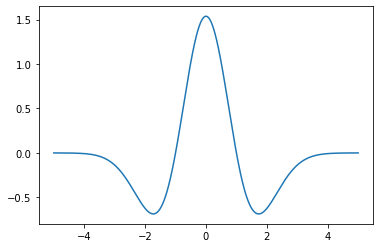

In [4]:
import mexhat_numpy
import matplotlib.pyplot as plt
import graphviz
xs, ys = mexhat_numpy.loop2()
plt.plot(xs,ys)
plt.show()
lle = LLE(rmse_threshold=50, verbose=1, split_type='greedy')

## Train the model

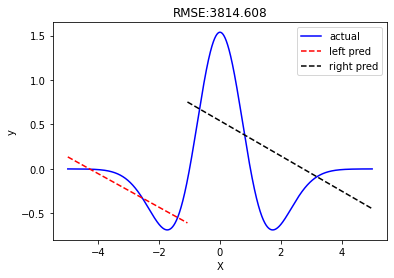

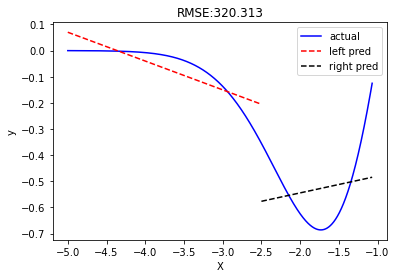

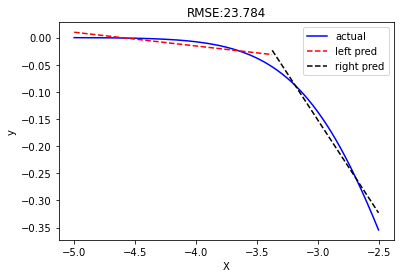

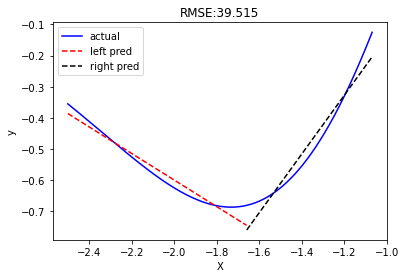

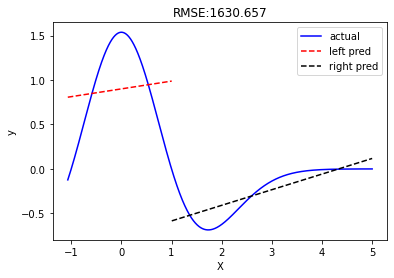

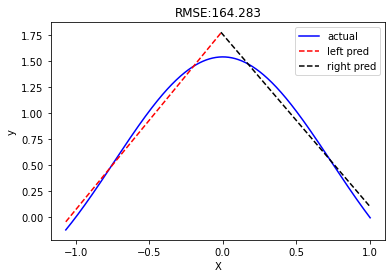

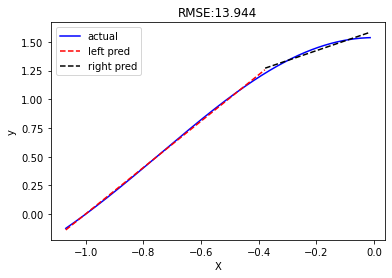

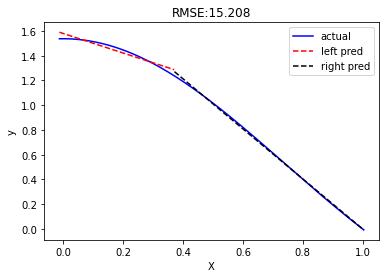

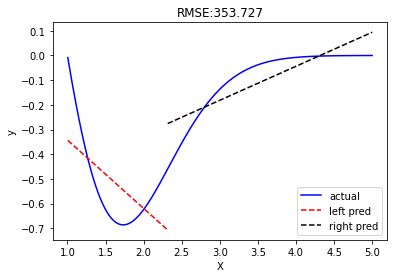

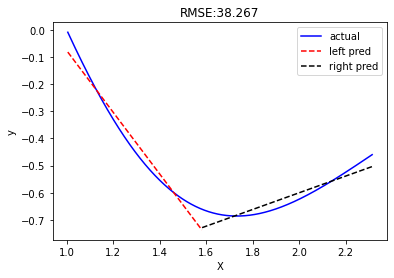

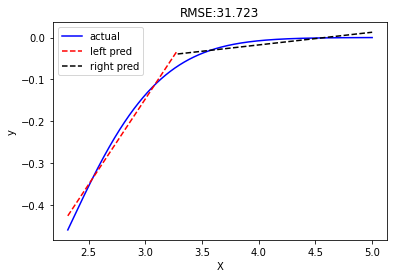

root-1
3070
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
65E0
rmse:503.0
xrange:(-5.0, -1.07)
│   ├── L-4
CD60
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
7EE0
rmse:11.0
xrange:(-5.0, -3.37)
│   │   └── R-7
7DC0
rmse:12.0
xrange:(-3.37, -2.5)
│   └── R-5
8DF0
rmse:196.0
xrange:(-2.5, -1.07)
│       ├── L-8
7D90
rmse:18.0
xrange:(-2.5, -1.66)
│       └── R-9
2DC0
rmse:21.0
xrange:(-1.66, -1.07)
└── R-3
7E80
rmse:3311.0
xrange:(-1.07, 5.0)
    ├── L-10
35E0
rmse:1056.0
xrange:(-1.07, 1.0)
    │   ├── L-12
45E0
rmse:80.0
xrange:(-1.07, -0.01)
    │   │   ├── L-14
F670
rmse:6.0
xrange:(-1.07, -0.38)
    │   │   └── R-15
2AC0
rmse:7.0
xrange:(-0.38, -0.01)
    │   └── R-13
5790
rmse:84.0
xrange:(-0.01, 1.0)
    │       ├── L-16
14C0
rmse:9.0
xrange:(-0.01, 0.37)
    │       └── R-17
EA90
rmse:6.0
xrange:(0.37, 1.0)
    └── R-11
9040
rmse:575.0
xrange:(1.0, 5.0)
        ├── L-18
B9D0
rmse:179.0
xrange:(1.0, 2.31)
        │   ├── L-20
B9A0
rmse:20.0
xrange:(1.0, 1.58)
        │   └── R-21
8D00
r

In [5]:
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

## Plot the tree

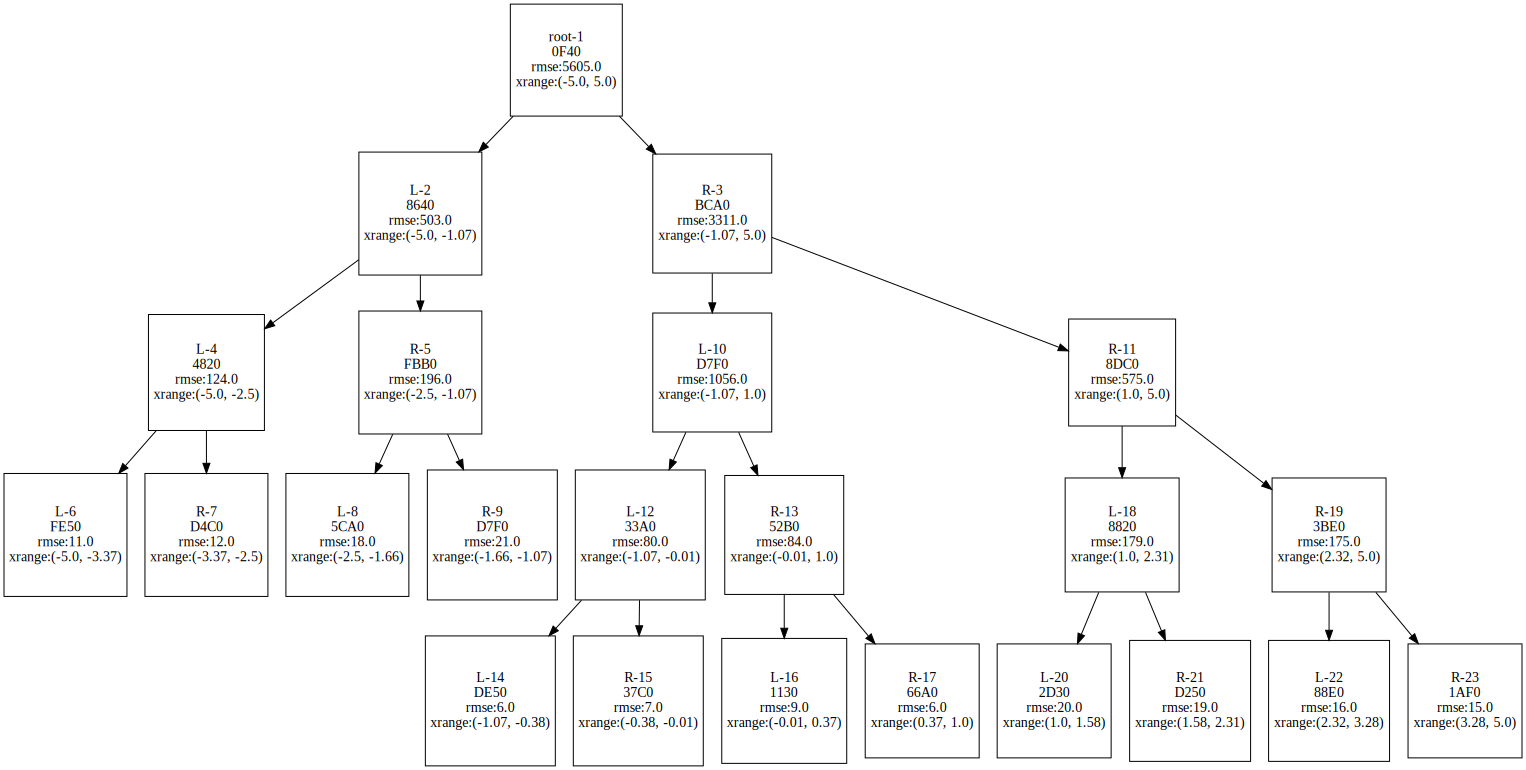

In [7]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Check which models were finalized

In [8]:
lle.final_models

{(-5.0, -3.37): LinearRegression(),
 (-3.37, -2.5): LinearRegression(),
 (-2.5, -1.66): LinearRegression(),
 (-1.66, -1.07): LinearRegression(),
 (-1.07, -0.38): LinearRegression(),
 (-0.38, -0.01): LinearRegression(),
 (-0.01, 0.37): LinearRegression(),
 (0.37, 1.0): LinearRegression(),
 (1.0, 1.58): LinearRegression(),
 (1.58, 2.31): LinearRegression(),
 (2.32, 3.28): LinearRegression(),
 (3.28, 5.0): LinearRegression(),
 (-0.01, 1.0): LinearRegression(),
 (-2.5, -1.07): LinearRegression()}

## Perform a prediction

In [9]:
x = -0.6
lle.predict(x)

array([[0.80960653]])

## Check how accurate the prediction is

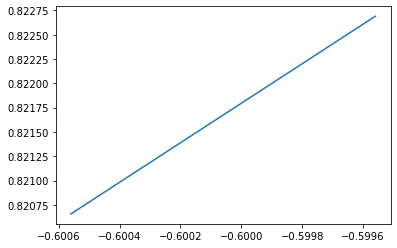

In [10]:
epsilon = 0.001
x_sub = xs[(x-epsilon<xs)&(xs<x+epsilon)]
y_sub = ys[(x-epsilon<xs)&(xs<x+epsilon)]
plt.plot(x_sub, y_sub)
plt.show()

**Observation:** For the value x=-0.6 we got a very accurate prediction of 0.81

## See how many linear models can we obtain by changing thresholds
<font color='red'>Warning!! Long running code</font>

In [10]:
thresholds = np.arange(5000, 0, -100)
from tqdm import tqdm
number_of_models = []
for threshold in tqdm(thresholds):
    lle = LLE(rmse_threshold=threshold, verbose=0)
    lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))
    number_of_models.append(len(lle.final_models))

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [11:48<00:00, 14.17s/it]


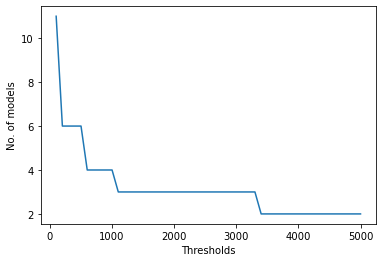

In [11]:
plt.plot(thresholds, number_of_models)
plt.xlabel('Thresholds')
plt.ylabel('No. of models')
plt.show()

## (Optional) Let's see how much of Mexican Hat could be reconstructed by our model
Also we will see what is the overall model accuracy

### Retrain the model with RMSE threshold = 10

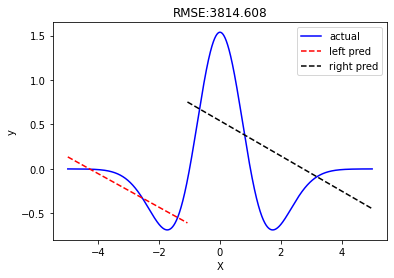

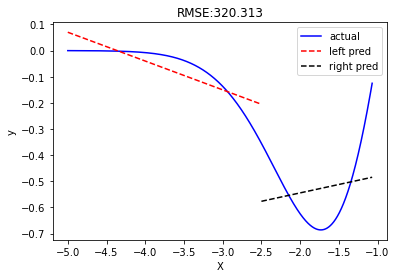

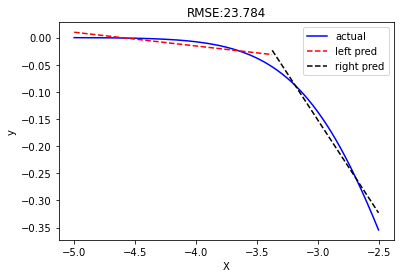

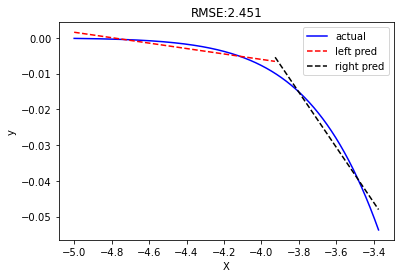

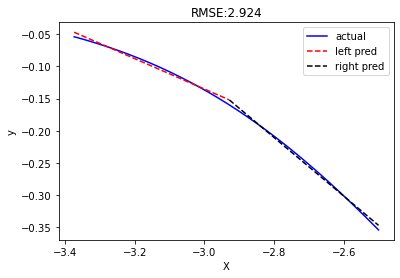

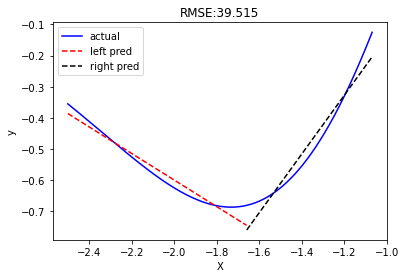

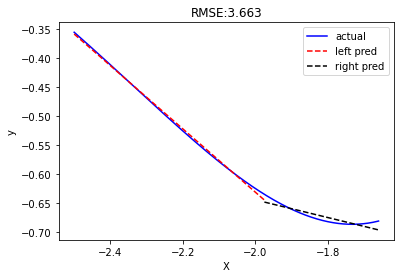

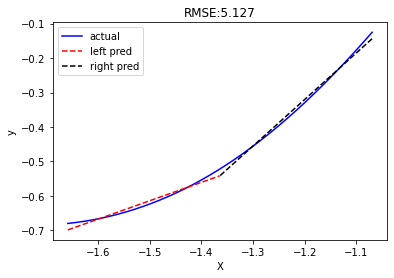

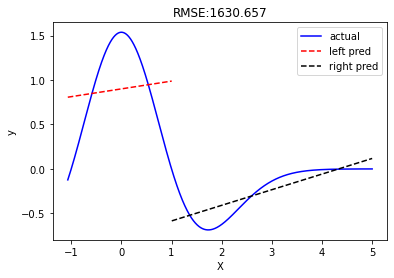

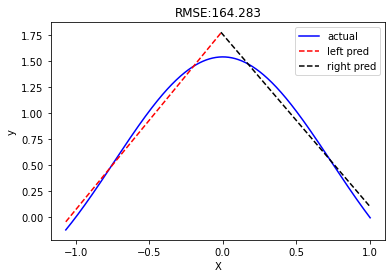

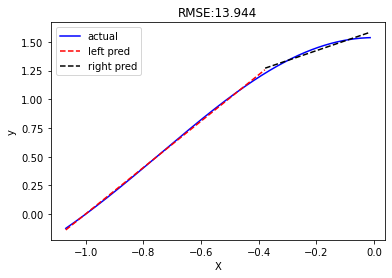

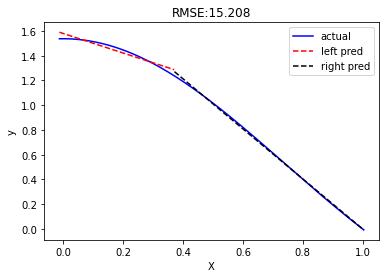

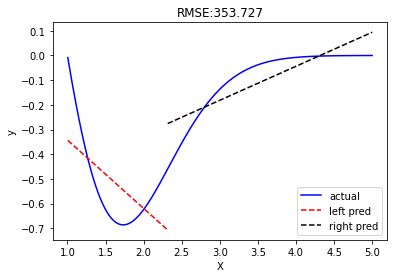

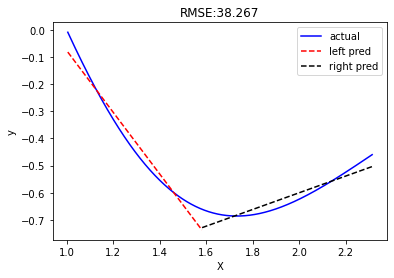

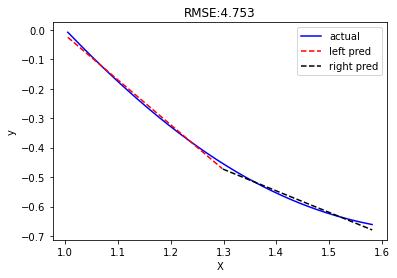

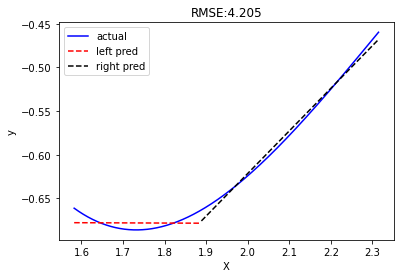

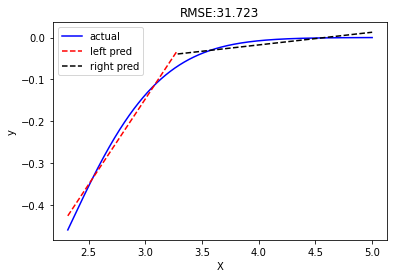

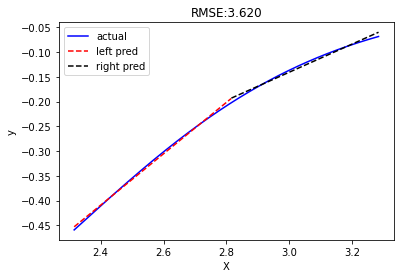

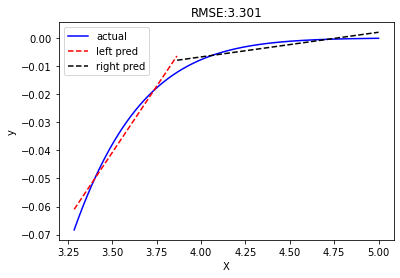

root-1
2A60
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
7730
rmse:503.0
xrange:(-5.0, -1.07)
│   ├── L-4
8730
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
2220
rmse:11.0
xrange:(-5.0, -3.37)
│   │   │   ├── L-8
5610
rmse:1.0
xrange:(-5.0, -3.93)
│   │   │   └── R-9
D070
rmse:1.0
xrange:(-3.93, -3.37)
│   │   └── R-7
13D0
rmse:12.0
xrange:(-3.37, -2.5)
│   │       ├── L-10
A8B0
rmse:1.0
xrange:(-3.37, -2.93)
│   │       └── R-11
F700
rmse:1.0
xrange:(-2.93, -2.5)
│   └── R-5
A6A0
rmse:196.0
xrange:(-2.5, -1.07)
│       ├── L-12
FB50
rmse:18.0
xrange:(-2.5, -1.66)
│       │   ├── L-14
9C10
rmse:2.0
xrange:(-2.5, -1.98)
│       │   └── R-15
D880
rmse:2.0
xrange:(-1.97, -1.66)
│       └── R-13
4EB0
rmse:21.0
xrange:(-1.66, -1.07)
│           ├── L-16
88B0
rmse:3.0
xrange:(-1.66, -1.36)
│           └── R-17
94F0
rmse:3.0
xrange:(-1.36, -1.07)
└── R-3
A3D0
rmse:3311.0
xrange:(-1.07, 5.0)
    ├── L-18
08B0
rmse:1056.0
xrange:(-1.07, 1.0)
    │   ├── L-20
A970
rmse:80.0
xrange:(-1.07, -0.01)
    

In [11]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

### See the final model and individual domains

In [12]:
lle.final_models

{(-5.0, -3.93): LinearRegression(),
 (-3.93, -3.37): LinearRegression(),
 (-3.37, -2.93): LinearRegression(),
 (-2.93, -2.5): LinearRegression(),
 (-2.5, -1.98): LinearRegression(),
 (-1.97, -1.66): LinearRegression(),
 (-1.66, -1.36): LinearRegression(),
 (-1.36, -1.07): LinearRegression(),
 (-3.37, -2.5): LinearRegression(),
 (-1.07, -0.38): LinearRegression(),
 (-0.38, -0.01): LinearRegression(),
 (-0.01, 0.37): LinearRegression(),
 (0.37, 1.0): LinearRegression(),
 (1.0, 1.3): LinearRegression(),
 (1.3, 1.58): LinearRegression(),
 (1.58, 1.89): LinearRegression(),
 (1.89, 2.31): LinearRegression(),
 (2.32, 2.81): LinearRegression(),
 (2.82, 3.28): LinearRegression(),
 (3.28, 3.86): LinearRegression(),
 (3.86, 5.0): LinearRegression(),
 (1.58, 2.31): LinearRegression(),
 (-0.01, 1.0): LinearRegression(),
 (-2.5, -1.07): LinearRegression()}

### Perform series of predictions
For x in mexican hat

In [13]:
from tqdm import tqdm
y_pred = []
y_true = ys
for x in tqdm(xs):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very narrow domain)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16038.96it/s]

Model not found for: 2.310731073107311 interpolating y: -0.5051973226671023
Model not found for: 2.3117311731173116 interpolating y: -0.5051973226671023
Model not found for: 2.312731273127313 interpolating y: -0.5051973226671023
Model not found for: 2.3137313731373137 interpolating y: -0.5051973226671023
Model not found for: 2.314731473147315 interpolating y: -0.5051973226671023
Model not found for: 2.315731573157316 interpolating y: -0.5051973226671023
Model not found for: 2.3167316731673164 interpolating y: -0.5051973226671023
Model not found for: 2.317731773177318 interpolating y: -0.5051973226671023
Model not found for: 2.3187318731873185 interpolating y: -0.5051973226671023
Model not found for: 2.31973197319732 interpolating y: -0.5051973226671023
Model not found for: 2.8107810781078104 interpolating y: -0.19653707734956227
Model not found for: 2.811781178117812 interpolating y: -0.19653707734956227
Model not found for: 2.8127812781278125 interpolating y: -0.19653707734956227
Mode

### Plot the two curves

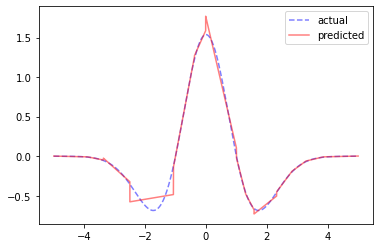

In [14]:
plt.plot(xs,ys,'--b',alpha=0.5,label='actual')
plt.plot(xs,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=ys, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=ys,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.05863536966851129
Overall pseudo R2: 0.9890550723626799


## (Optional) Let's see how much of Mexican Hat could be reconstructed by our model with split_type as 'binary'
Our algo also supports binary splitting. The default is greedy split where we split by a partition giving the best RMSE. In case of binary split, the splitting is always done by bisecting the x_range. We will see:
1. The algorithm is much faster.
2. But less accurate

### Retrain the model with RMSE threshold = 10

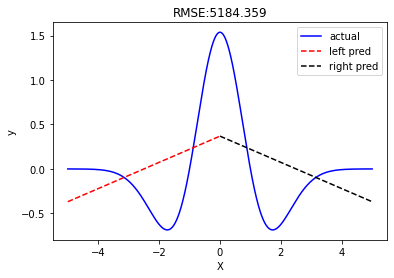

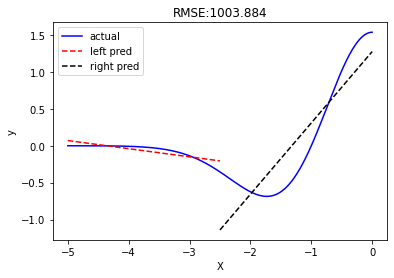

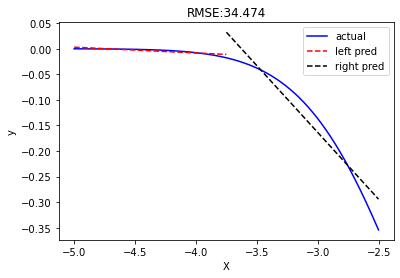

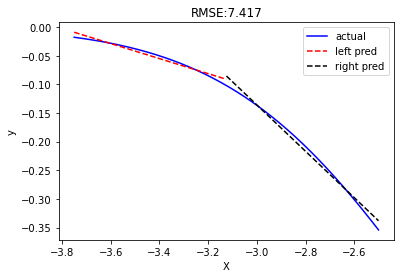

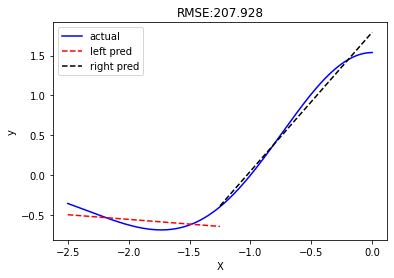

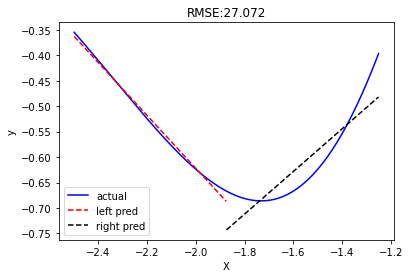

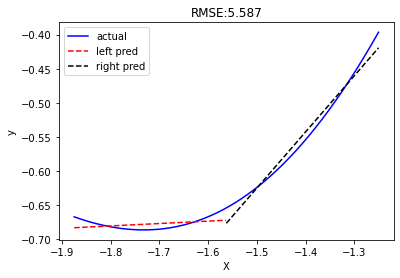

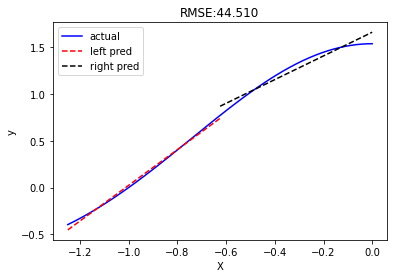

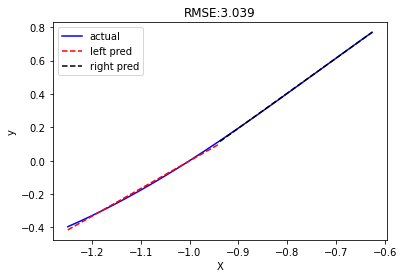

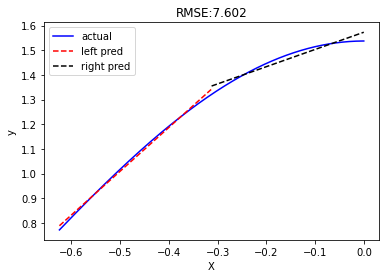

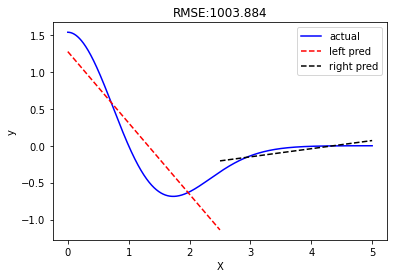

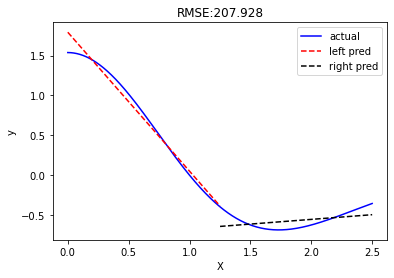

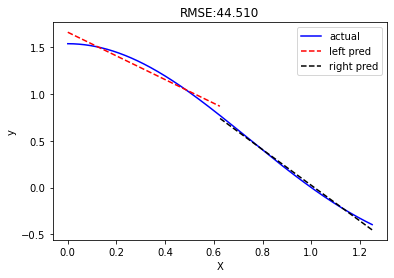

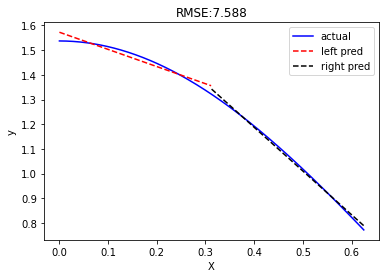

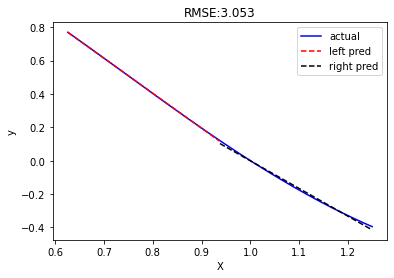

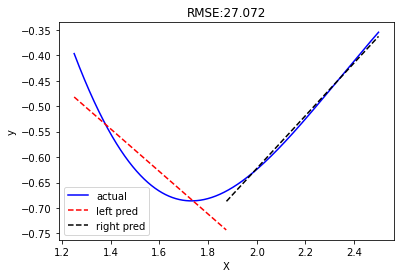

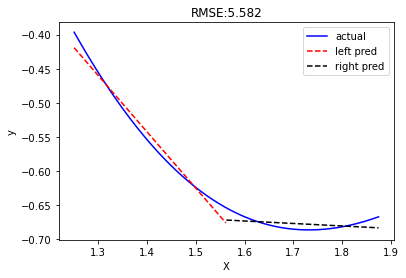

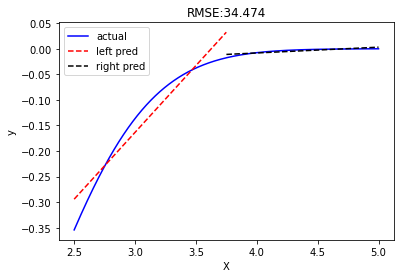

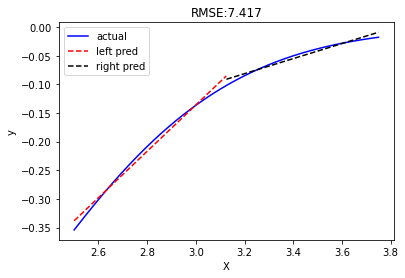

root-1
E910
rmse:5605.0
xrange:(-5.0, 5.0)
├── L-2
A070
rmse:2592.0
xrange:(-5.0, -0.0)
│   ├── L-4
6790
rmse:124.0
xrange:(-5.0, -2.5)
│   │   ├── L-6
6C40
rmse:3.0
xrange:(-5.0, -3.75)
│   │   └── R-7
6EB0
rmse:32.0
xrange:(-3.75, -2.5)
│   │       ├── L-8
2430
rmse:3.0
xrange:(-3.75, -3.13)
│   │       └── R-9
AD30
rmse:5.0
xrange:(-3.12, -2.5)
│   └── R-5
7370
rmse:879.0
xrange:(-2.5, -0.0)
│       ├── L-10
5610
rmse:112.0
xrange:(-2.5, -1.25)
│       │   ├── L-12
B550
rmse:4.0
xrange:(-2.5, -1.88)
│       │   └── R-13
38B0
rmse:23.0
xrange:(-1.87, -1.25)
│       │       ├── L-14
AA30
rmse:2.0
xrange:(-1.87, -1.56)
│       │       └── R-15
AC70
rmse:3.0
xrange:(-1.56, -1.25)
│       └── R-11
40A0
rmse:96.0
xrange:(-1.25, -0.0)
│           ├── L-16
88B0
rmse:13.0
xrange:(-1.25, -0.63)
│           │   ├── L-18
2B20
rmse:3.0
xrange:(-1.25, -0.94)
│           │   └── R-19
D700
rmse:0.0
xrange:(-0.94, -0.63)
│           └── R-17
17F0
rmse:31.0
xrange:(-0.62, -0.0)
│               ├── L-

In [16]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='binary')
lle.fit(X=xs.reshape(-1,1), y=ys.reshape(-1,1))

### Plot the tree

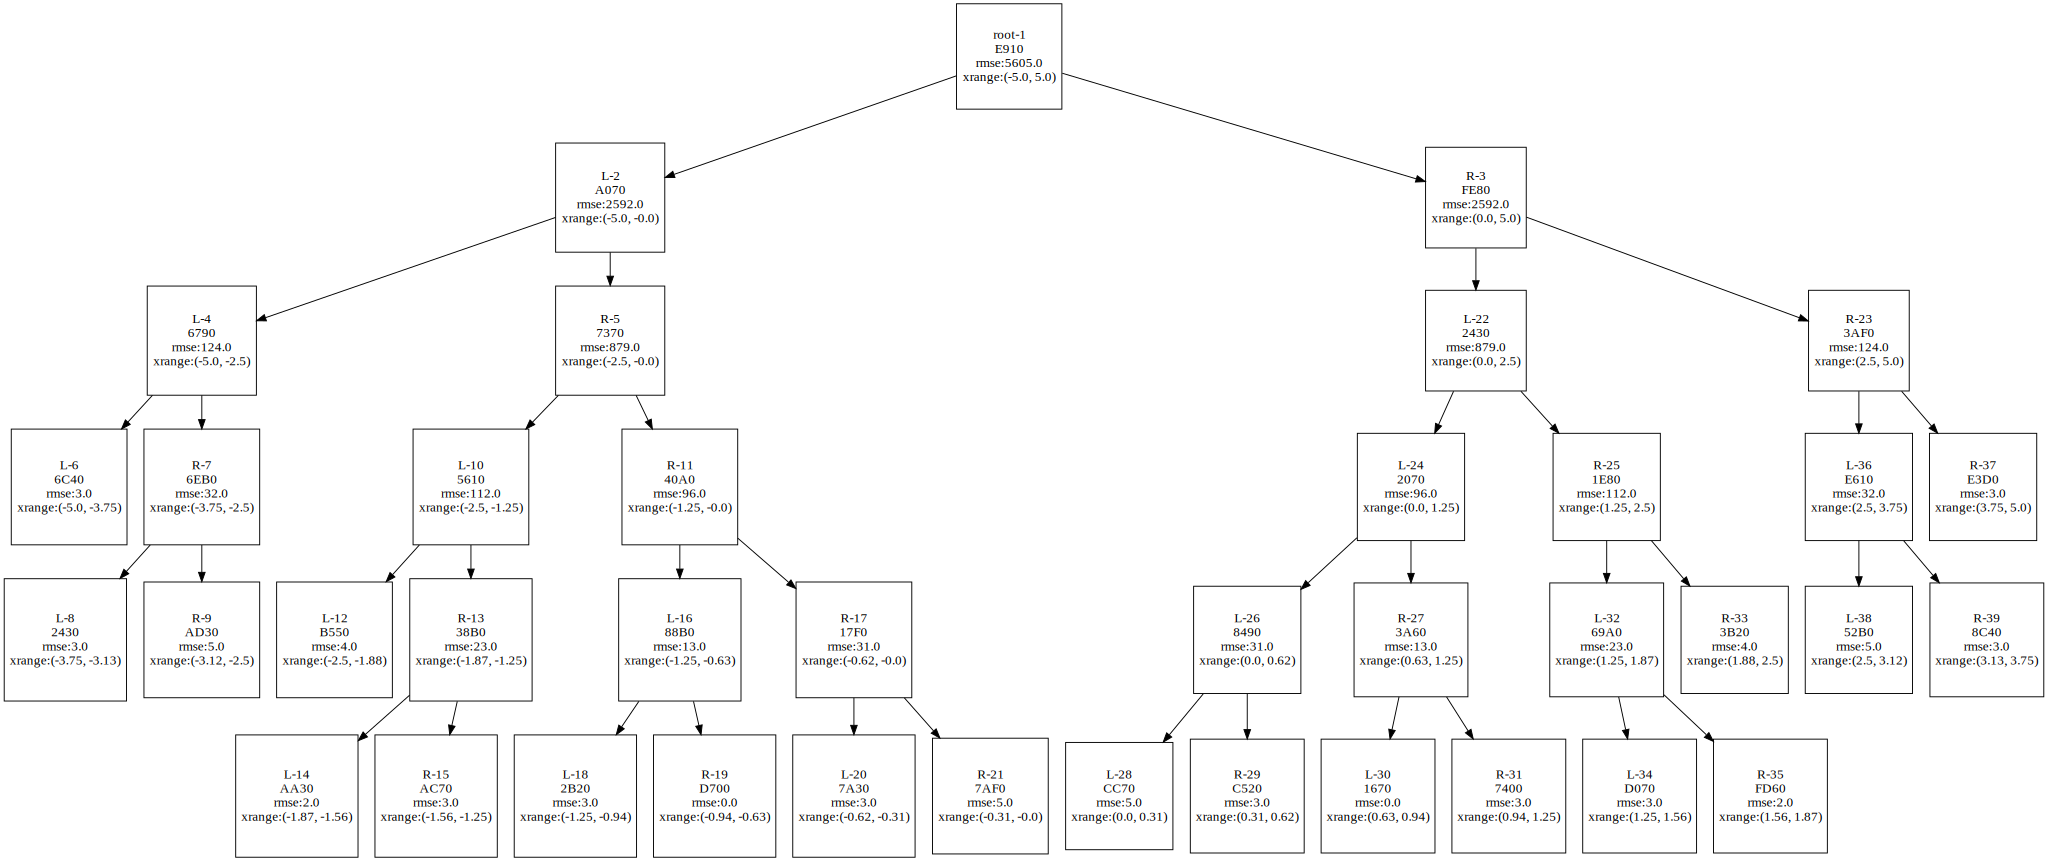

In [17]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### See the final model and the X value ranges

In [19]:
lle.final_models

{(-5.0, -3.75): LinearRegression(),
 (-3.75, -3.13): LinearRegression(),
 (-3.12, -2.5): LinearRegression(),
 (-2.5, -1.88): LinearRegression(),
 (-1.87, -1.56): LinearRegression(),
 (-1.56, -1.25): LinearRegression(),
 (-1.25, -0.94): LinearRegression(),
 (-0.94, -0.63): LinearRegression(),
 (-0.62, -0.31): LinearRegression(),
 (-0.31, -0.0): LinearRegression(),
 (-1.87, -1.25): LinearRegression(),
 (-3.75, -2.5): LinearRegression(),
 (0.0, 0.31): LinearRegression(),
 (0.31, 0.62): LinearRegression(),
 (0.63, 0.94): LinearRegression(),
 (0.94, 1.25): LinearRegression(),
 (1.25, 1.56): LinearRegression(),
 (1.56, 1.87): LinearRegression(),
 (1.88, 2.5): LinearRegression(),
 (0.63, 1.25): LinearRegression(),
 (2.5, 3.12): LinearRegression(),
 (3.13, 3.75): LinearRegression(),
 (3.75, 5.0): LinearRegression(),
 (1.25, 2.5): LinearRegression(),
 (-2.5, -0.0): LinearRegression()}

### Perform series of predictions
For x in mexican hat

In [20]:
y_pred = []
y_true = ys
for x in tqdm(xs):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

 76%|██████████████████████████████████████████████████████▍                 | 7558/10000 [00:00<00:00, 12315.48it/s]

Model not found for: 0.6205620562056202 interpolating y: 0.7974254907946718
Model not found for: 0.6215621562156217 interpolating y: 0.7974254907946718
Model not found for: 0.6225622562256223 interpolating y: 0.7974254907946718
Model not found for: 0.6235623562356238 interpolating y: 0.7974254907946718
Model not found for: 0.6245624562456245 interpolating y: 0.7974254907946718
Model not found for: 0.625562556255626 interpolating y: 0.7974254907946718
Model not found for: 0.6265626562656266 interpolating y: 0.7974254907946718
Model not found for: 0.6275627562756272 interpolating y: 0.7974254907946718
Model not found for: 0.6285628562856287 interpolating y: 0.7974254907946718
Model not found for: 0.6295629562956293 interpolating y: 0.7974254907946718
Model not found for: 3.12081208120812 interpolating y: -0.08746739515381252
Model not found for: 3.1218121812181217 interpolating y: -0.08746739515381252
Model not found for: 3.122812281228123 interpolating y: -0.08746739515381252
Model not 

100%|███████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13860.82it/s]


### Plot the two curves

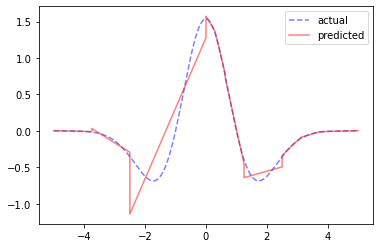

In [21]:
plt.plot(xs,ys,'--b',alpha=0.5,label='actual')
plt.plot(xs,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=ys, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=ys,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.17907286364096786
Overall pseudo R2: 0.8979170723170712


## (Optional) Enough! Does our model work on the Happy path scenario?
Happy path is a dataset which is already linear in nature. Expectation is we should have only **one** model in the final

### Simulate such data

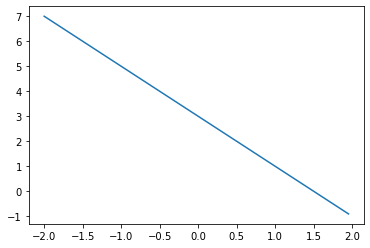

In [23]:
x_list = np.arange(-2,2,0.05)
y_list = -2*x_list + 3
plt.plot(x_list, y_list)
plt.show()

### Retrain the model with RMSE threshold = 50

In [24]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

root-1
D2B0
rmse:0.0
xrange:(-2.0, 1.95)



### See the final model and the X value ranges

In [25]:
lle.final_models

{(-2.0, 1.95): LinearRegression()}

**Observation:** Final model is only one. Niiice!

### Perform series of predictions
For x in mexican hat

In [26]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|█████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 16028.68it/s]

Model not found for: 1.9500000000000037 interpolating y: -0.8000000000000065


### Plot the two curves

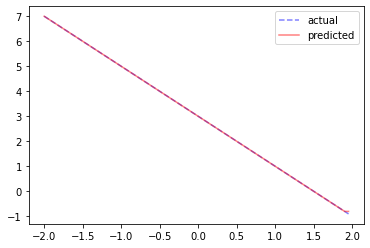

In [27]:
plt.plot(x_list,y_list,'--b',alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

### Get the overall RMSE and pseudo R<sup>2</sup>

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.011180339887499058
Overall pseudo R2: 0.9999765588373183


## (Optional) How is noise sensitivity in happy path scenarios?
Happy path is a dataset which is already linear in nature. 
<br>Here we will introduce random gaussian noise to y
<br>The question we are asking **Is our model robust to random noises?**

### Simulate such data

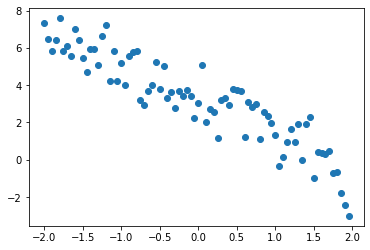

In [29]:
x_list = np.arange(-2,2,0.05)
y_list = -2*x_list + 3 + np.random.randn(len(x_list))
plt.scatter(x_list, y_list)
plt.show()

### The Greedy Split Algorithm

#### Retrain the model with RMSE threshold = 10

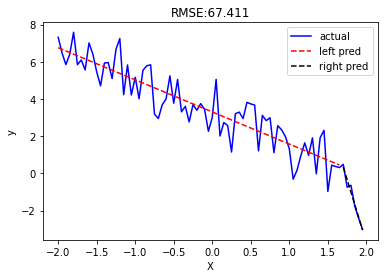

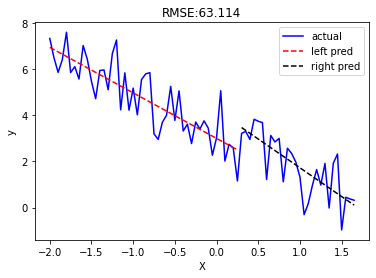

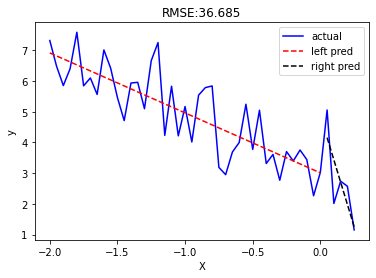

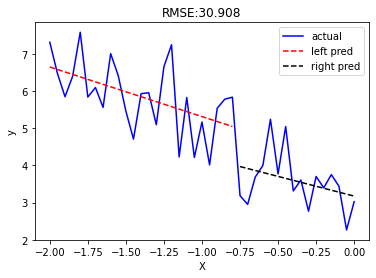

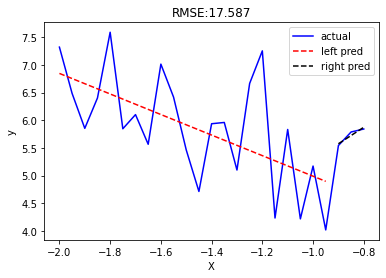

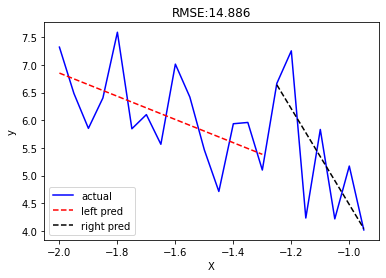

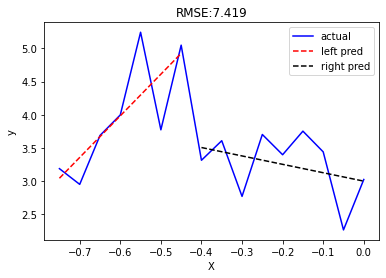

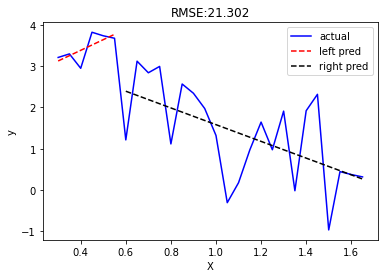

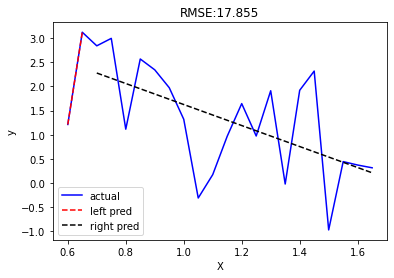

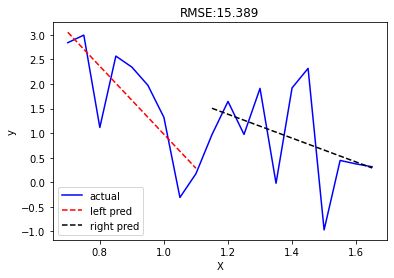

root-1
F880
rmse:77.0
xrange:(-2.0, 1.95)
├── L-2
8970
rmse:66.0
xrange:(-2.0, 1.65)
│   ├── L-4
4310
rmse:39.0
xrange:(-2.0, 0.25)
│   │   ├── L-6
3B50
rmse:33.0
xrange:(-2.0, 0.0)
│   │   │   ├── L-8
BF10
rmse:20.0
xrange:(-2.0, -0.8)
│   │   │   │   ├── L-10
5E50
rmse:17.0
xrange:(-2.0, -0.95)
│   │   │   │   │   ├── L-12
D2E0
rmse:9.0
xrange:(-2.0, -1.3)
│   │   │   │   │   └── R-13
1880
rmse:6.0
xrange:(-1.25, -0.95)
│   │   │   │   └── R-11
8F70
rmse:0.0
xrange:(-0.9, -0.8)
│   │   │   └── R-9
B220
rmse:11.0
xrange:(-0.75, 0.0)
│   │   │       ├── L-14
8DF0
rmse:4.0
xrange:(-0.75, -0.45)
│   │   │       └── R-15
E280
rmse:4.0
xrange:(-0.4, 0.0)
│   │   └── R-7
BC40
rmse:4.0
xrange:(0.05, 0.25)
│   └── R-5
0BB0
rmse:24.0
xrange:(0.3, 1.65)
│       ├── L-16
3DC0
rmse:1.0
xrange:(0.3, 0.55)
│       └── R-17
1C70
rmse:20.0
xrange:(0.6, 1.65)
│           ├── L-18
25E0
rmse:0.0
xrange:(0.6, 0.65)
│           └── R-19
C7C0
rmse:18.0
xrange:(0.7, 1.65)
│               ├── L-20
C970
rmse:

In [30]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='greedy')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

#### Perform series of predictions
For x in custom dataset

In [31]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|██████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 8021.43it/s]

Model not found for: -1.2999999999999994 interpolating y: 5.488094476011248
Model not found for: -0.9499999999999991 interpolating y: 4.474684371159821
Model not found for: -0.7999999999999989 interpolating y: 5.723375408144985
Model not found for: 1.7763568394002505e-15 interpolating y: 3.2279426829540157
Model not found for: 0.2500000000000018 interpolating y: 1.981483702430276
Model not found for: 1.650000000000003 interpolating y: 0.22703584908002128
Model not found for: 1.9500000000000037 interpolating y: -2.3605976070555137


#### Plot the two curves

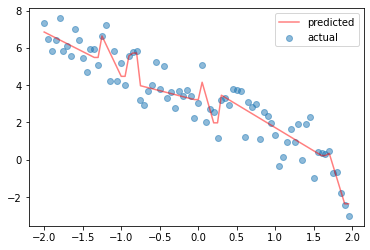

In [32]:
plt.scatter(x_list,y_list,alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

#### Get the overall RMSE and pseudo R<sup>2</sup>

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.736748192518261
Overall pseudo R2: 0.9046536457076775


**Observation:** As expected our greedy algorithm is not much robust to noises. Let's see how the binary one does on random noise

### Binary Split Algorithm

#### Retrain the model with RMSE threshold = 50

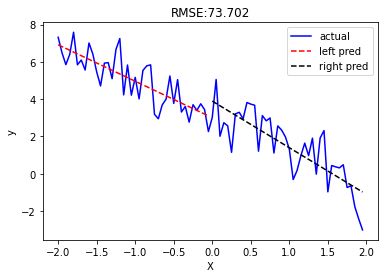

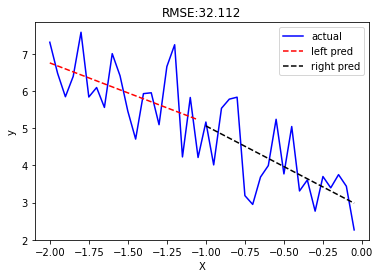

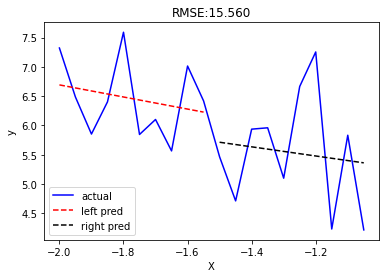

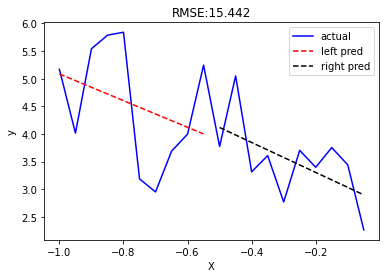

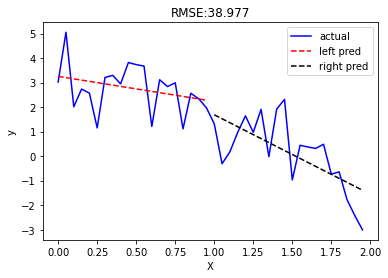

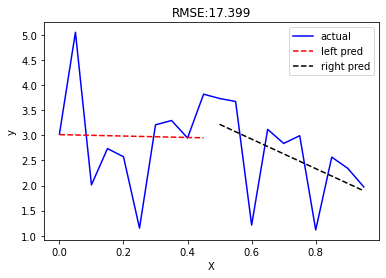

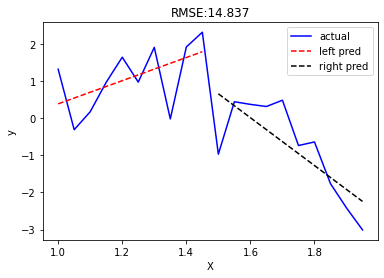

root-1
E940
rmse:77.0
xrange:(-2.0, 1.95)
├── L-2
B760
rmse:32.0
xrange:(-2.0, -0.05)
│   ├── L-4
7760
rmse:16.0
xrange:(-2.0, -1.05)
│   │   ├── L-6
4FD0
rmse:6.0
xrange:(-2.0, -1.55)
│   │   └── R-7
0130
rmse:9.0
xrange:(-1.5, -1.05)
│   └── R-5
E790
rmse:16.0
xrange:(-1.0, -0.05)
│       ├── L-8
2220
rmse:10.0
xrange:(-1.0, -0.55)
│       └── R-9
07C0
rmse:6.0
xrange:(-0.5, -0.05)
└── R-3
5670
rmse:41.0
xrange:(0.0, 1.95)
    ├── L-10
AB50
rmse:18.0
xrange:(0.0, 0.95)
    │   ├── L-12
2E50
rmse:10.0
xrange:(0.0, 0.45)
    │   └── R-13
18B0
rmse:8.0
xrange:(0.5, 0.95)
    └── R-11
25E0
rmse:21.0
xrange:(1.0, 1.95)
        ├── L-14
E3D0
rmse:7.0
xrange:(1.0, 1.45)
        └── R-15
2700
rmse:8.0
xrange:(1.5, 1.95)



In [34]:
lle = LLE(rmse_threshold=10, verbose=1, split_type='binary')
lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))

#### Perform series of predictions
For x in custom dataset

In [35]:
y_pred = []
y_true = y_list
for x in tqdm(x_list):
    try:
        y_hat = lle.predict(x)[0][0]
    except UnboundLocalError as e:
        # it may so happen due to discretization of x_ranges
        ## some values not covered (very few)
        ## for those X's extrapolate previous y_hat
        print('Model not found for: {} interpolating y: {}'.format(x, y_hat))
    y_pred.append(y_hat)

100%|████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<?, ?it/s]

Model not found for: -1.5499999999999996 interpolating y: 6.278847607100811
Model not found for: -1.0499999999999992 interpolating y: 5.399972545156243
Model not found for: -0.04999999999999827 interpolating y: 3.0937664836325136
Model not found for: 0.45000000000000195 interpolating y: 2.9588878791786386
Model not found for: 0.9500000000000028 interpolating y: 2.0425020573698007
Model not found for: 1.4500000000000028 interpolating y: 1.6363409943324485
Model not found for: 1.9500000000000037 interpolating y: -1.9198636604888009


### Plot the two curves

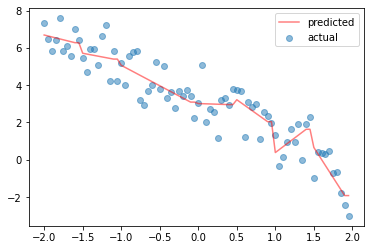

In [36]:
plt.scatter(x_list,y_list,alpha=0.5,label='actual')
plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
plt.legend()
plt.show()

#### Get the overall RMSE and pseudo R<sup>2</sup>

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_true=y_list, y_pred=y_pred,squared=False)
r2 = r2_score(y_true=y_list,y_pred=y_pred)
print('Overall RMSE: {}\nOverall pseudo R2: {}'.format(rmse,r2))

Overall RMSE: 0.8133775423816142
Overall pseudo R2: 0.8837881839093716


**Observation:** Even the binary split strategy is not much robust to noises but bit better than the greedy approach

### Change in model robustness with changing RMSE threshold
Below for different threshold we will train and perform prediction and see the model's robustness to the noises

### The Greedy Split Algorithm

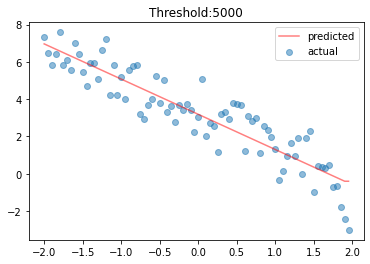

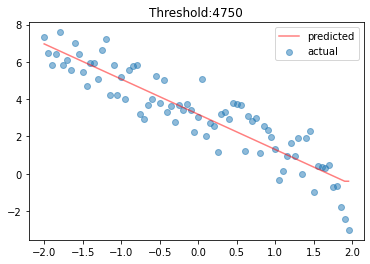

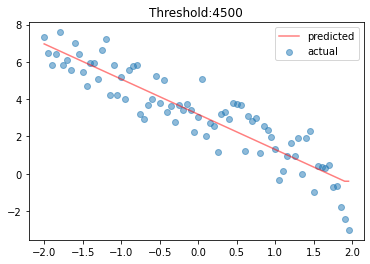

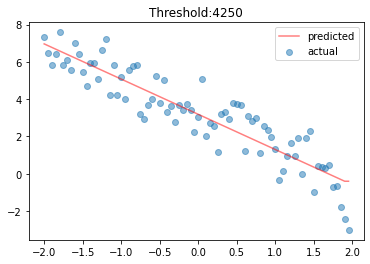

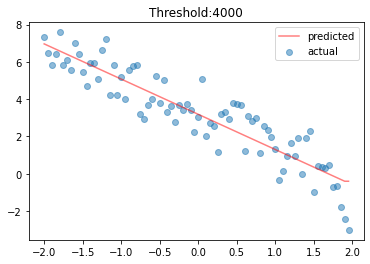

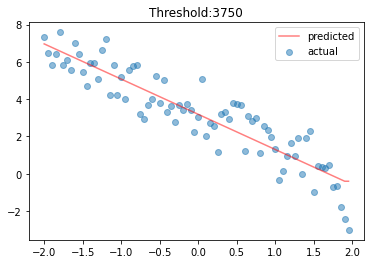

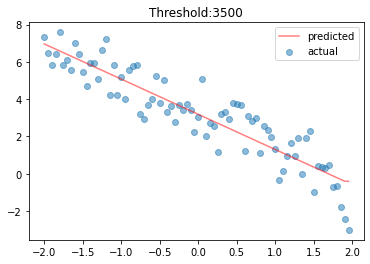

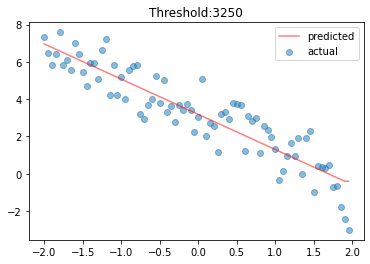

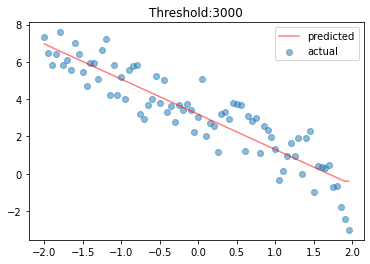

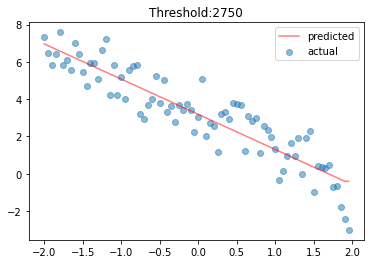

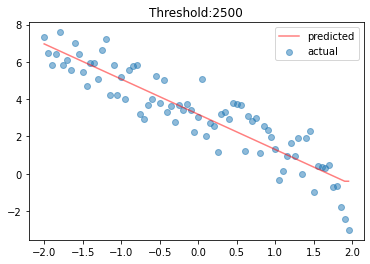

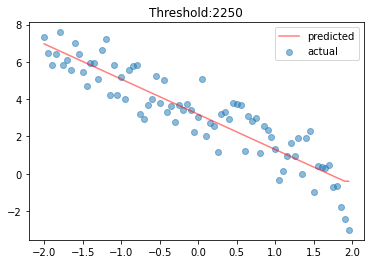

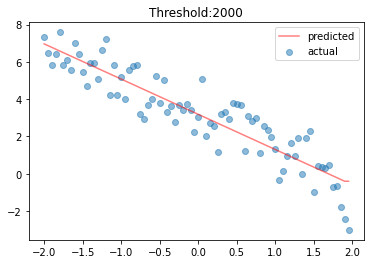

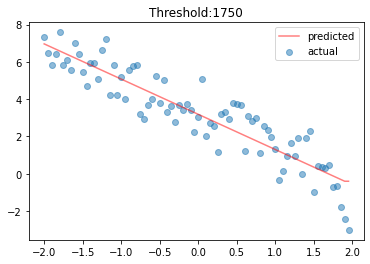

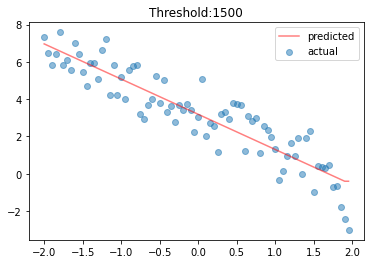

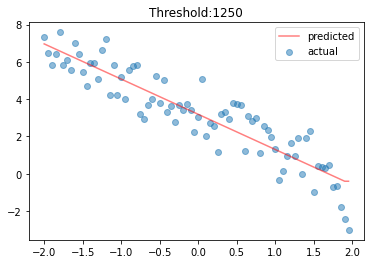

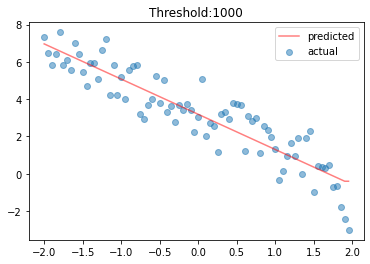

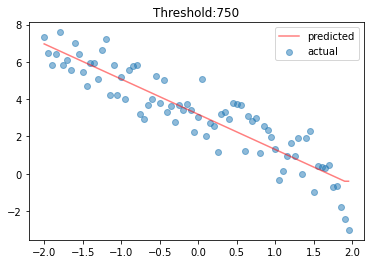

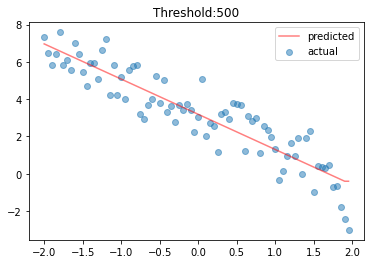

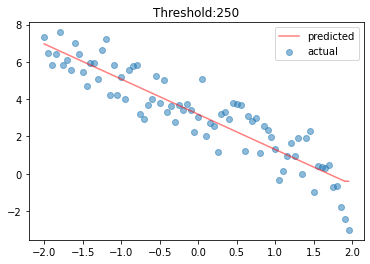

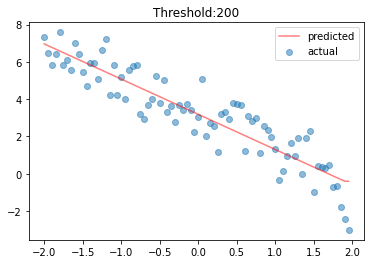

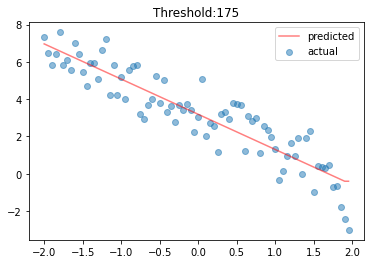

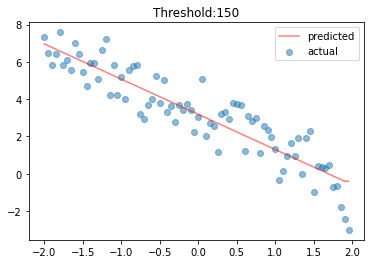

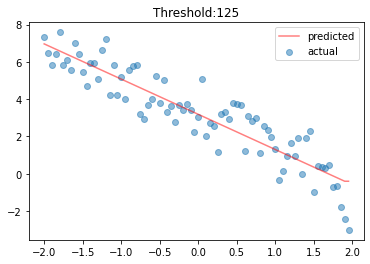

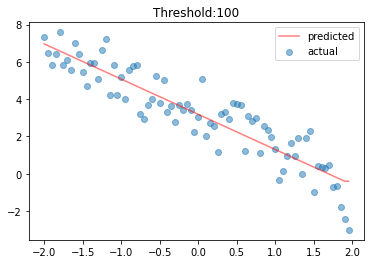

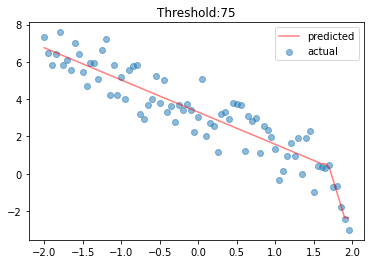

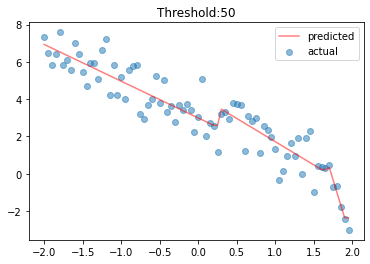

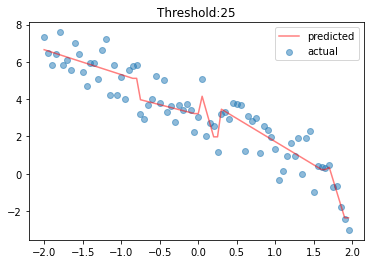

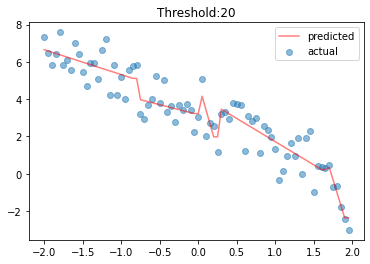

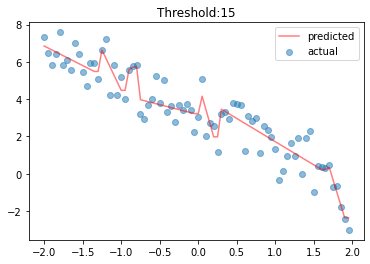

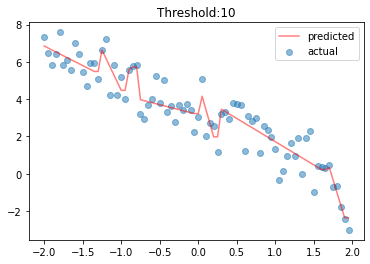

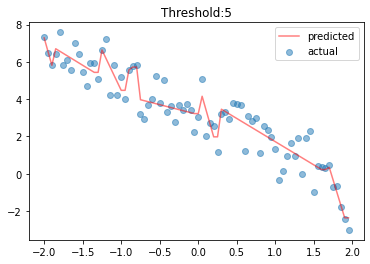

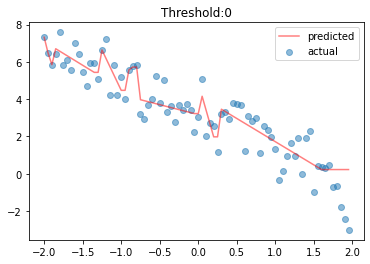

In [39]:
thresholds = list(np.arange(5000, 0, -250))
thresholds.extend(np.arange(200,0,-25))
thresholds.extend(np.arange(20,-5,-5))
for threshold in thresholds:
    lle = LLE(rmse_threshold=threshold, verbose=0, split_type='greedy')
    lle.fit(X=x_list.reshape(-1,1), y=y_list.reshape(-1,1))
    # run predictions
    y_pred = []
    y_true = y_list
    for x in x_list:
        try:
            y_hat = lle.predict(x)[0][0]
        except UnboundLocalError as e:
            # it may so happen due to discretization of x_ranges
            ## some values not covered (very few)
            ## for those X's extrapolate previous y_hat
            pass
        y_pred.append(y_hat)
    
    #### Plot the two curves
    plt.scatter(x_list,y_list,alpha=0.5,label='actual')
    plt.plot(x_list,y_pred,'-r',alpha=0.5, label='predicted')
    plt.legend()
    plt.title('Threshold:{}'.format(threshold))
    plt.show()

**Observation:** Thus we can see that with decrease in threshold value we could control the bias variance tradeoff of our algorithm to random noises.